# Compare protein abundance across U2OS and DUAL assays

In [1]:
import polars as pl
import plotnine as plotnine

In [2]:
prof_dir = "/dgx1nas1/storage/data/jess/repos/2021_09_01_VarChAMP/6.downstream_analysis_snakemake/outputs/batch_profiles"

In [22]:
sc_abun_stats = pl.read_csv("../results/sc_abundance_changes.csv")
well_abun_stats = pl.read_csv("../results/well_abundance_changes.csv")
assayable_genes = pl.read_csv("../results/assayable_genes.tsv", separator="\t").select("genes").unique().to_series().to_list()

In [35]:
# Compare to dual data
dual_col = "z_pdest_gfp_only"
dual_abun = (
    pl.read_csv("../results/pdest_dual_avg_wt_alleles_z-score-gfp.tsv", separator="\t")
    .filter(pl.col("node_type") == "allele")
    .with_columns(
        pl.concat_str(["symbol", "aa_change"], separator="_").alias("Variant")
    )
    .select(["Variant", dual_col])
    .filter(pl.col(dual_col).is_not_null())
    .with_columns(pl.col(dual_col).cast(pl.Float64))
    .rename({dual_col: "dual_Z"})
)
abun_dual_sc = sc_abun_stats.join(dual_abun, on="Variant", how="left").filter(
    pl.col("dual_Z").is_not_null()
)
abun_dual_well = well_abun_stats.join(dual_abun, on="Variant", how="left").filter(
    pl.col("dual_Z").is_not_null()
)

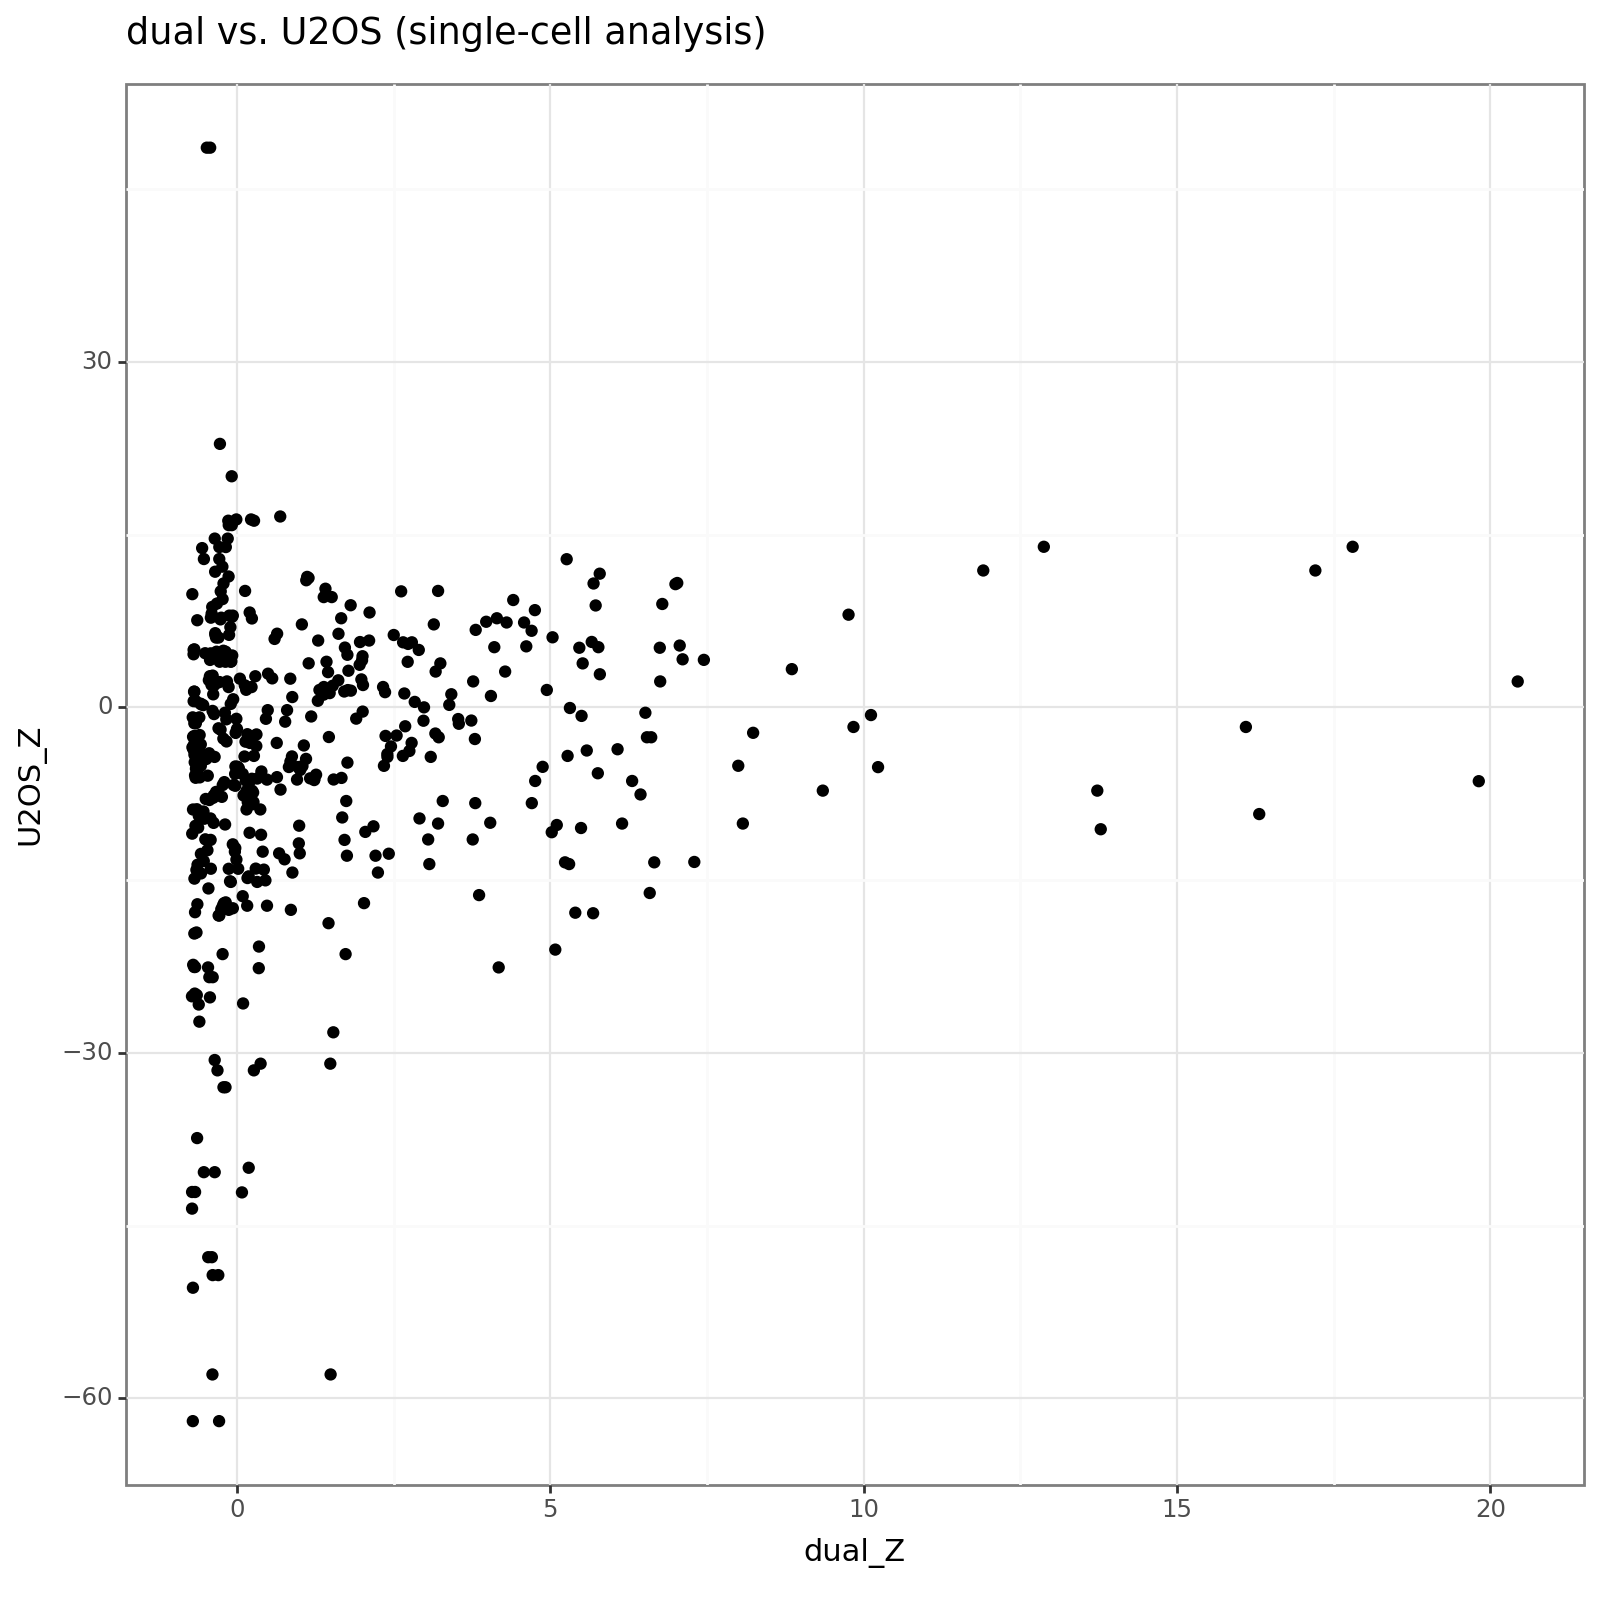

In [29]:
from plotnine import aes, geom_point, ggplot, theme_bw, labs

plotnine.options.figure_size = (8, 8)
plot1 = (
    ggplot(
        abun_dual_sc,
        aes(x="dual_Z", y="U2OS_Z"),
    )
    + geom_point()
    + theme_bw()
    + labs(title="dual vs. U2OS (single-cell analysis)")
)
print(plot1)

In [36]:
from scipy.stats import pearsonr

u2os_z = abun_dual_sc["U2OS_Z"].to_numpy()
dual_z = abun_dual_sc["dual_Z"].to_numpy()

corr_coeff, p_value = pearsonr(u2os_z, dual_z)

print("SC stats: ")
print(f"Pearson correlation coefficient: {corr_coeff}")
print(f"P-value: {p_value}")

SC stats: 
Pearson correlation coefficient: 0.15802052091049956
P-value: 0.0005469449343806096


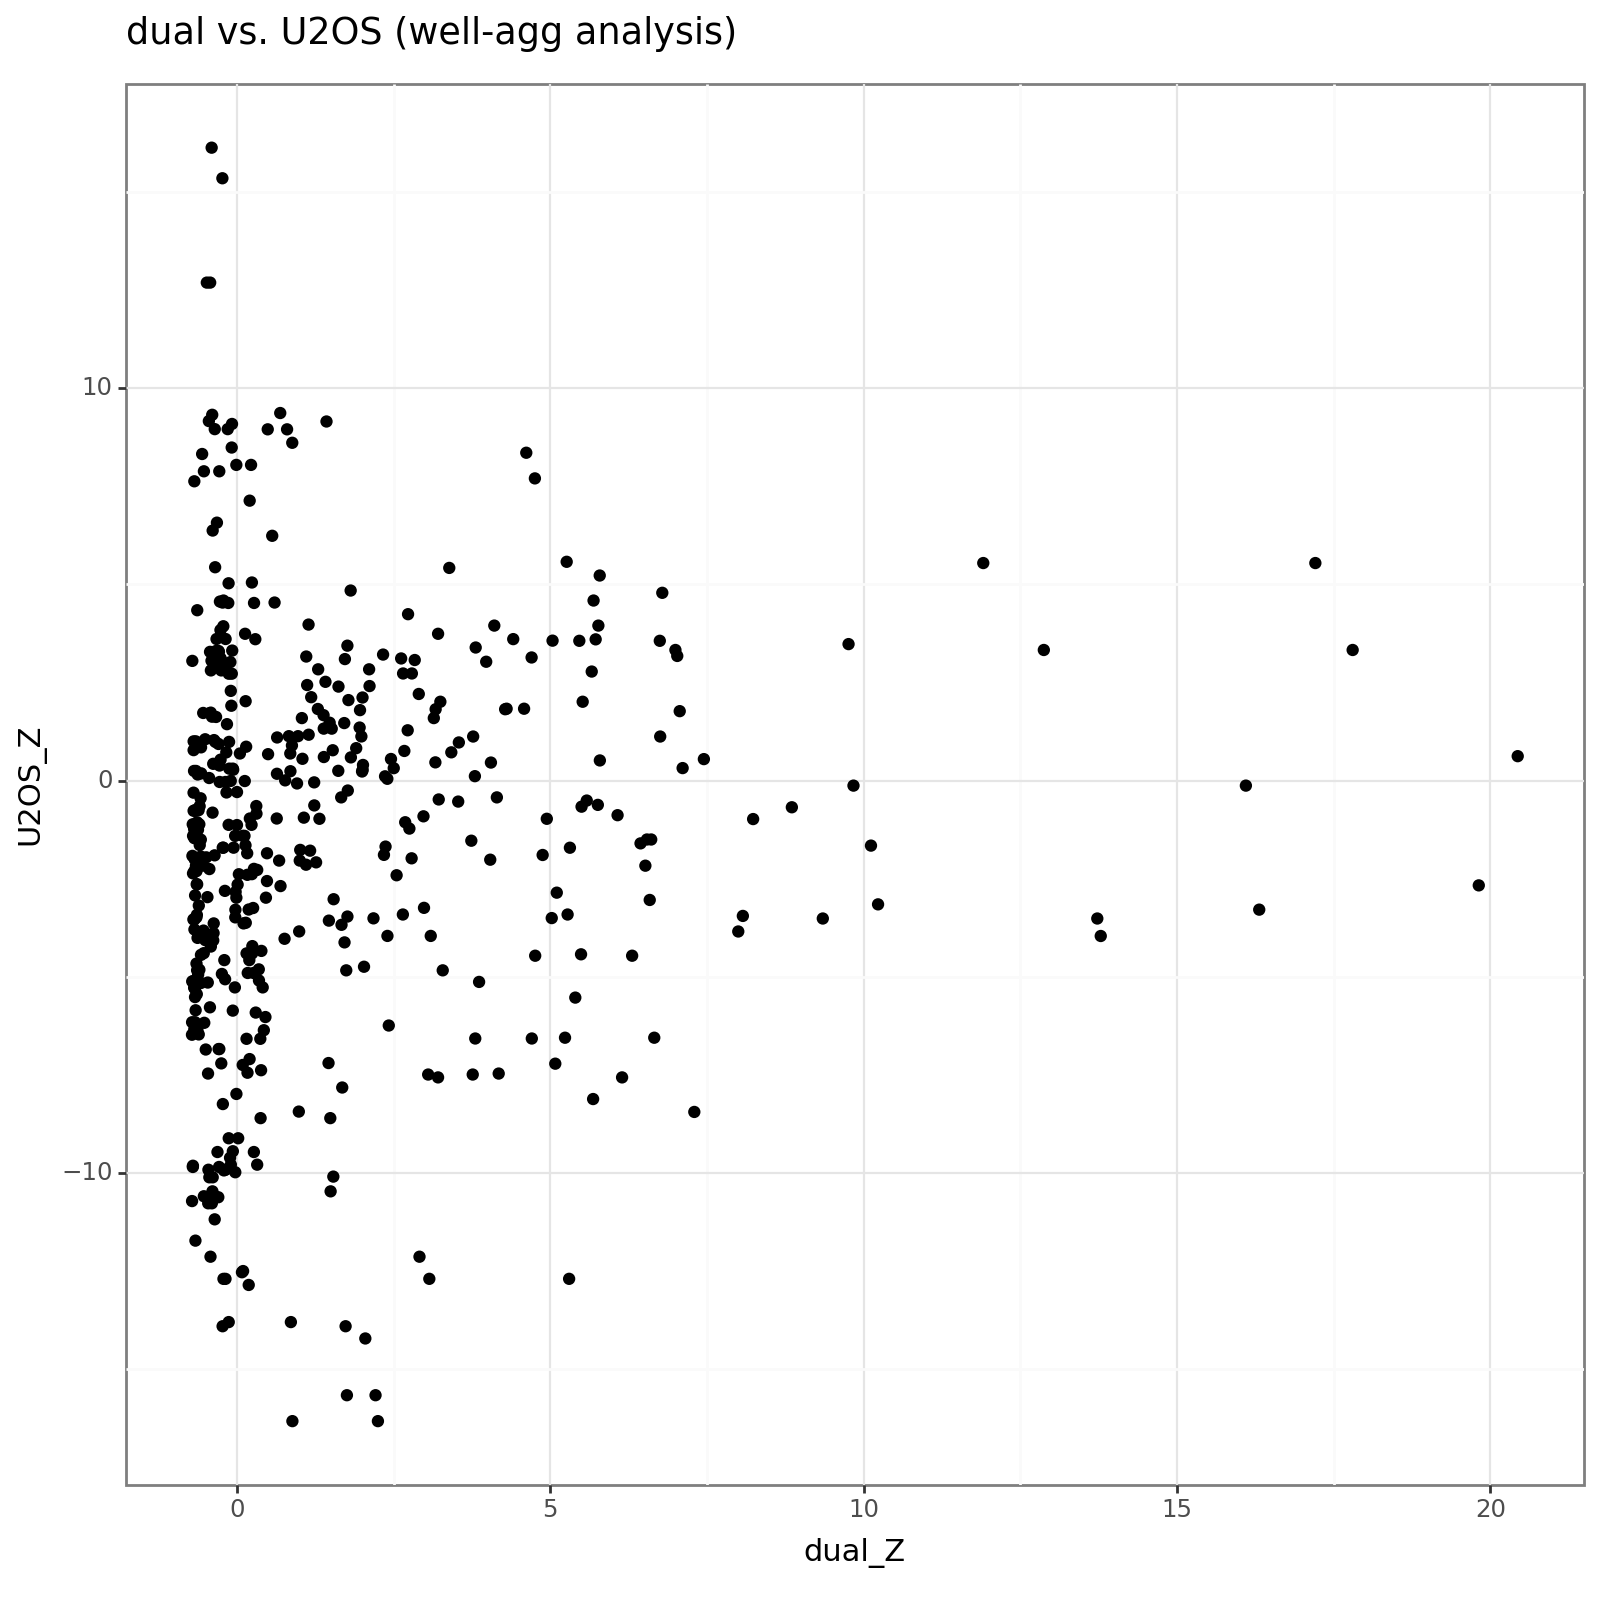

In [31]:
from plotnine import aes, geom_point, ggplot, theme_bw, labs

plotnine.options.figure_size = (8, 8)
plot1 = (
    ggplot(
        abun_dual_well,
        aes(x="dual_Z", y="U2OS_Z"),
    )
    + geom_point()
    + theme_bw()
    + labs(title="dual vs. U2OS (well-agg analysis)")
)
print(plot1)

In [37]:
from scipy.stats import pearsonr

u2os_z = abun_dual_well["U2OS_Z"].to_numpy()
dual_z = abun_dual_well["dual_Z"].to_numpy()

corr_coeff, p_value = pearsonr(u2os_z, dual_z)

print("Well-agg stats: ")
print(f"Pearson correlation coefficient: {corr_coeff}")
print(f"P-value: {p_value}")

Well-agg stats: 
Pearson correlation coefficient: 0.10517507333705434
P-value: 0.021873366010673214


(475, 9)
(355, 9)


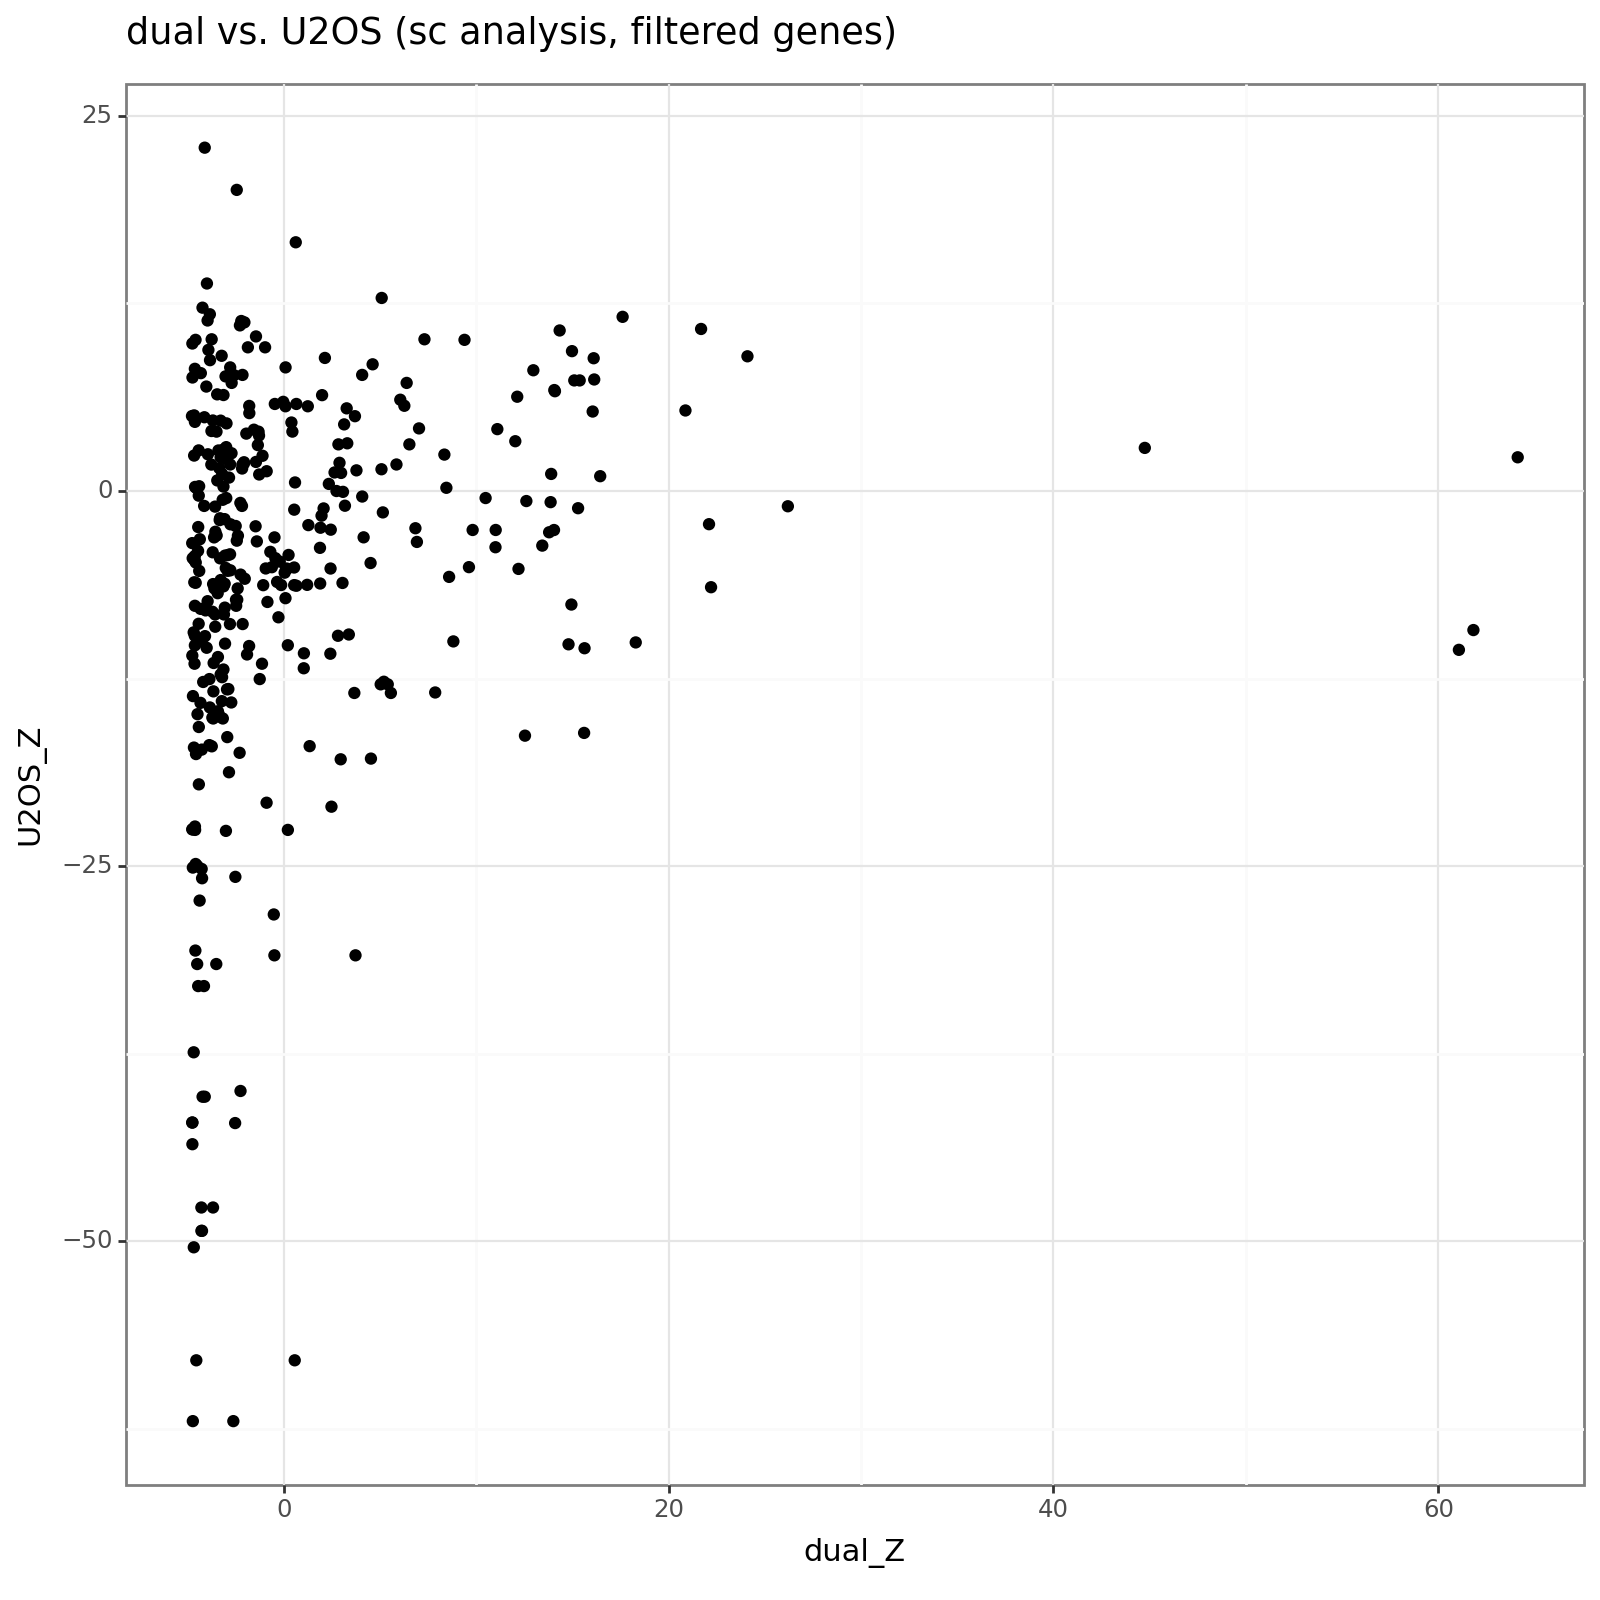


SC stats: 
Pearson correlation coefficient: 0.19237658312199432
P-value: 0.0002663727834160477


In [38]:
# re-analyze after filtering to only include assayable genes
print(abun_dual_sc.shape)
abun_dual_sc_filt = abun_dual_sc.filter(pl.col("Gene").is_in(assayable_genes))
print(abun_dual_sc_filt.shape)

from plotnine import aes, geom_point, ggplot, theme_bw, labs

plotnine.options.figure_size = (8, 8)
plot1 = (
    ggplot(
        abun_dual_sc_filt,
        aes(x="dual_Z", y="U2OS_Z"),
    )
    + geom_point()
    + theme_bw()
    + labs(title="dual vs. U2OS (sc analysis, filtered genes)")
)
print(plot1)

u2os_z = abun_dual_sc_filt["U2OS_Z"].to_numpy()
dual_z = abun_dual_sc_filt["dual_Z"].to_numpy()

corr_coeff, p_value = pearsonr(u2os_z, dual_z)

print("SC stats: ")
print(f"Pearson correlation coefficient: {corr_coeff}")
print(f"P-value: {p_value}")

(475, 9)
(355, 9)


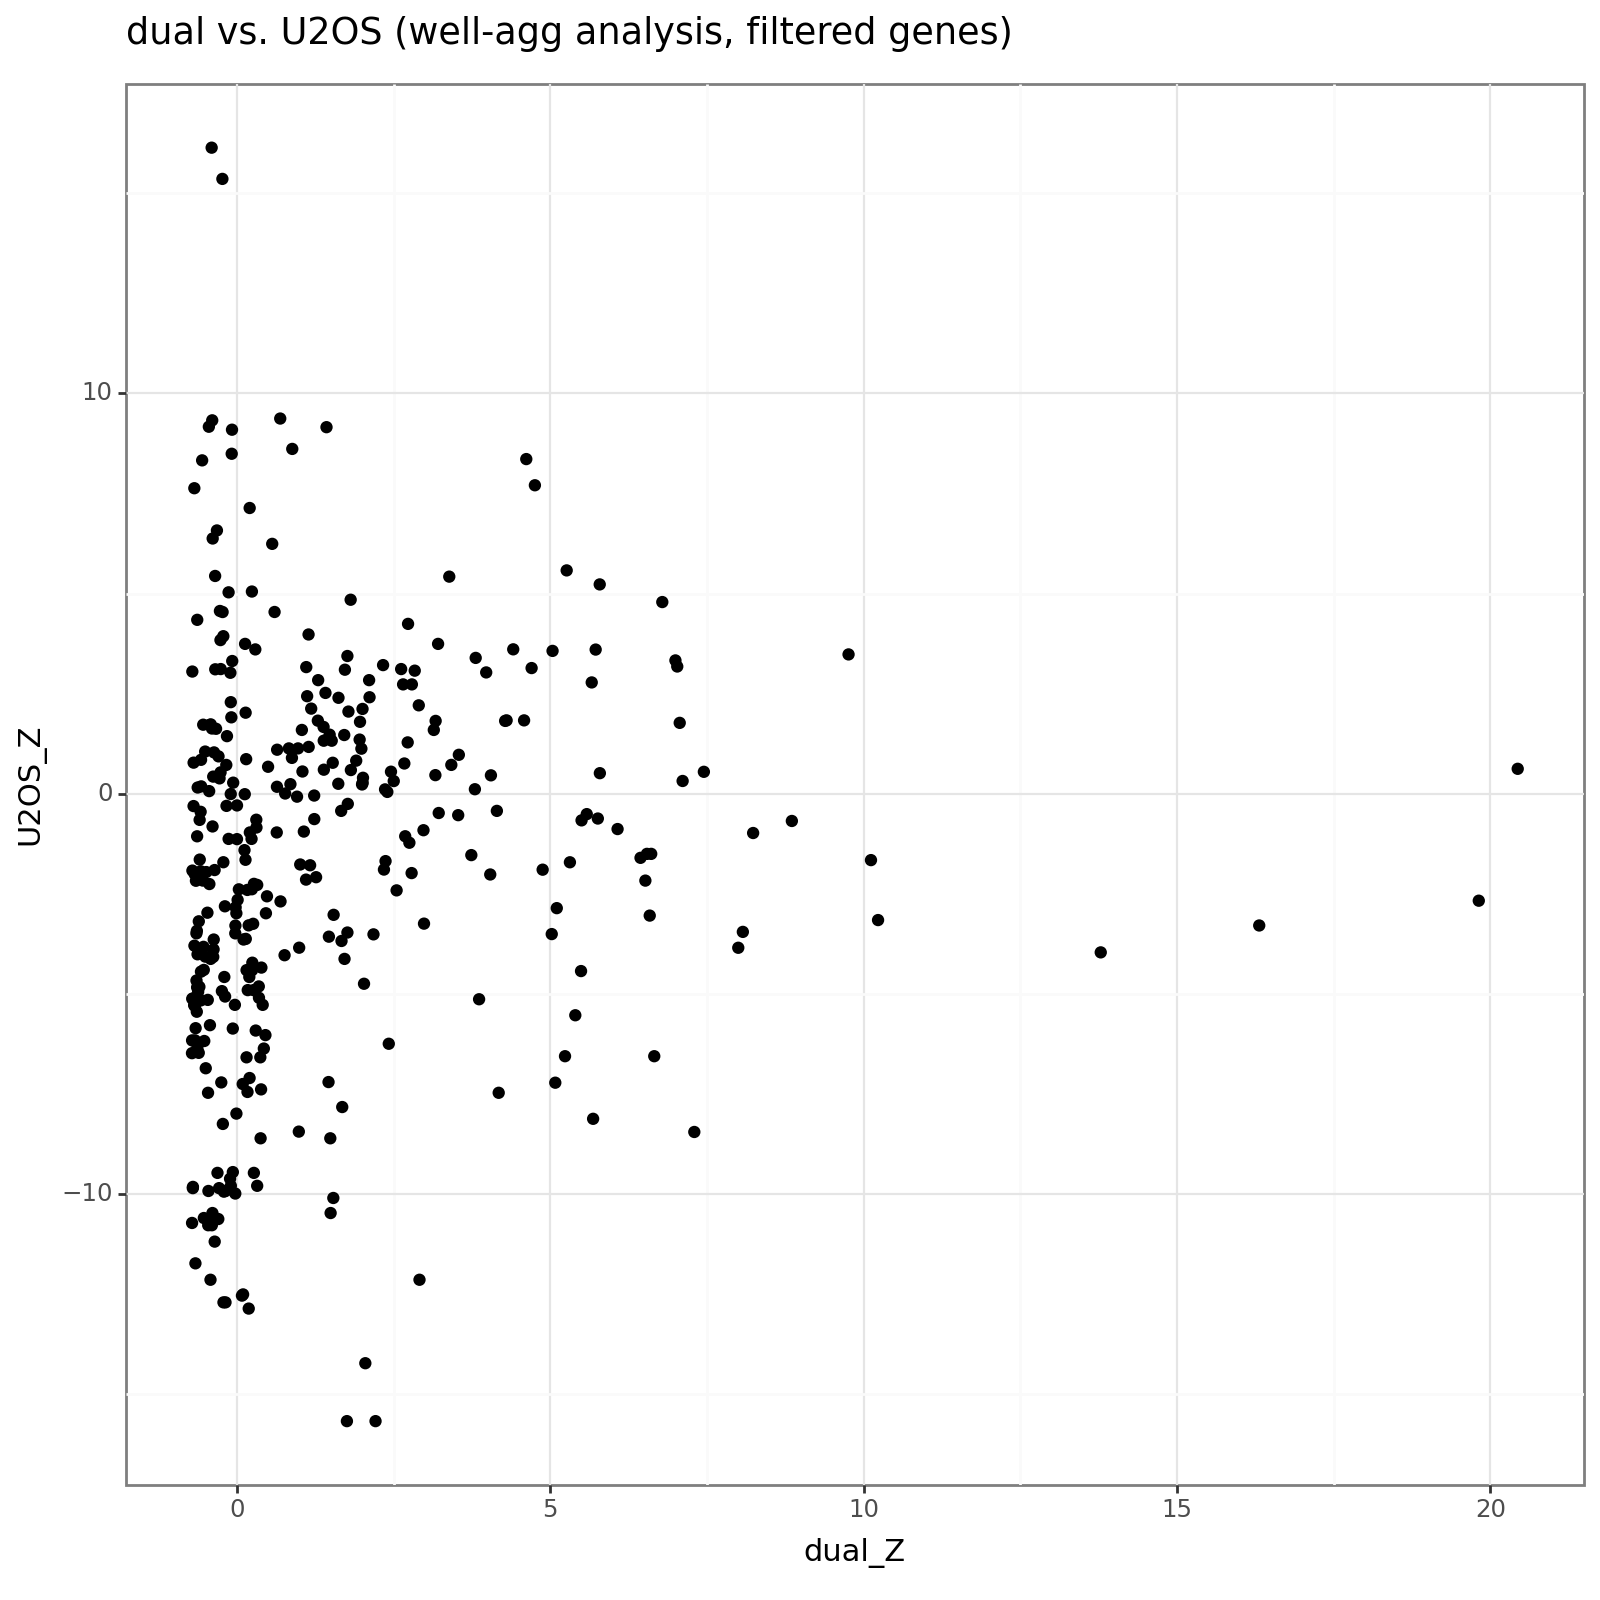


Well-agg stats: 
Pearson correlation coefficient: 0.12911352765718354
P-value: 0.014920504417739846


In [34]:
# re-analyze after filtering to only include assayable genes
print(abun_dual_well.shape)
abun_dual_well_filt = abun_dual_well.filter(pl.col("Gene").is_in(assayable_genes))
print(abun_dual_well_filt.shape)

from plotnine import aes, geom_point, ggplot, theme_bw, labs

plotnine.options.figure_size = (8, 8)
plot1 = (
    ggplot(
        abun_dual_well_filt,
        aes(x="dual_Z", y="U2OS_Z"),
    )
    + geom_point()
    + theme_bw()
    + labs(title="dual vs. U2OS (well-agg analysis, filtered genes)")
)
print(plot1)

u2os_z = abun_dual_well_filt["U2OS_Z"].to_numpy()
dual_z = abun_dual_well_filt["dual_Z"].to_numpy()

corr_coeff, p_value = pearsonr(u2os_z, dual_z)

print("Well-agg stats: ")
print(f"Pearson correlation coefficient: {corr_coeff}")
print(f"P-value: {p_value}")

/dgx1nas1/storage/data/jess/miniforge3/envs/varchamp/lib/python3.8/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 17'. Pick better value with 'binwidth'.


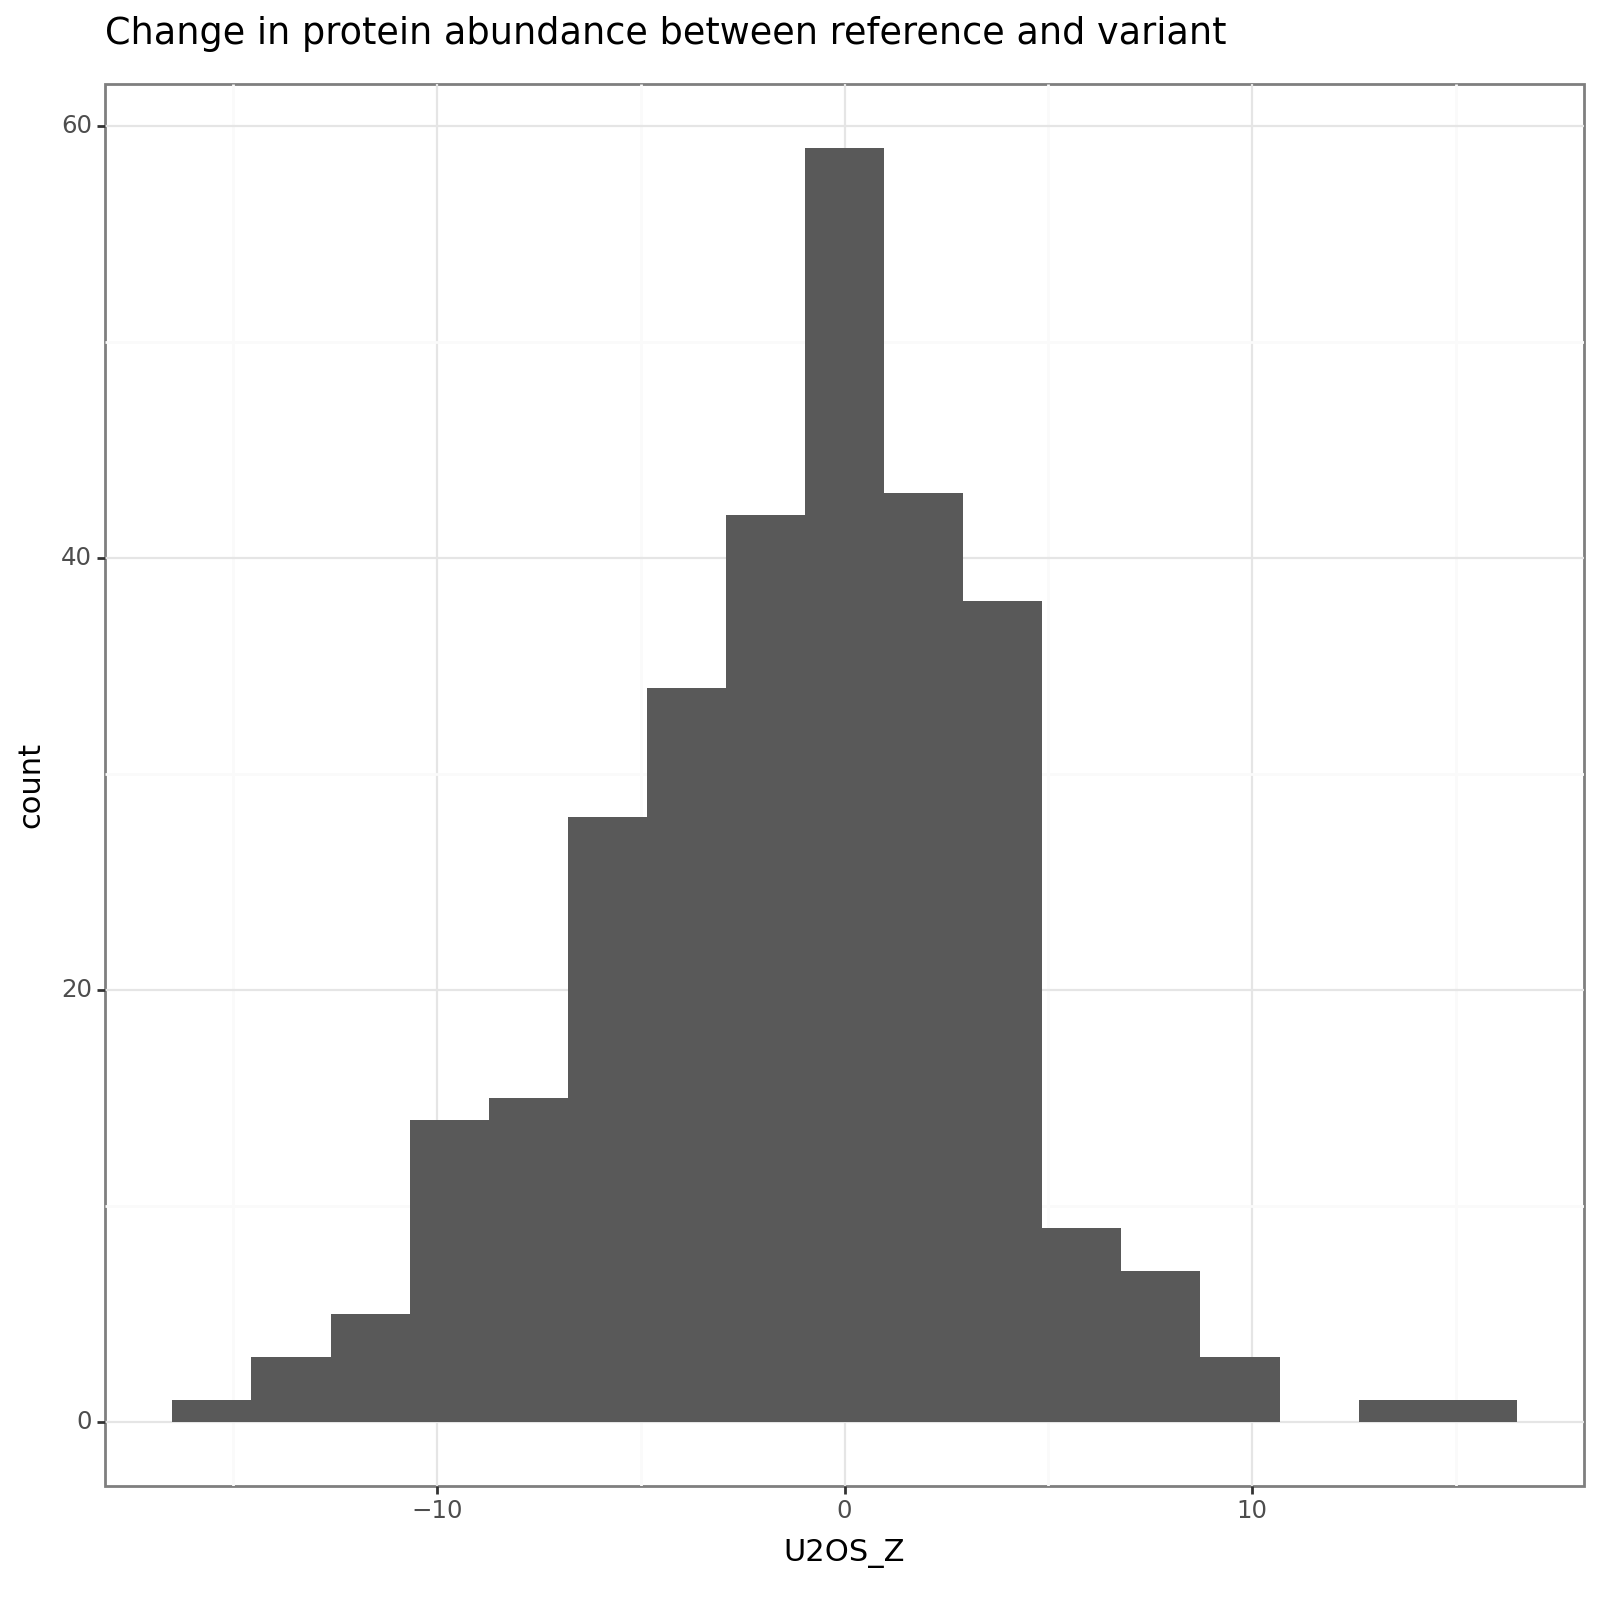

In [9]:
from plotnine import aes, geom_histogram, ggplot, theme_bw, labs

plotnine.options.figure_size = (8, 8)
plot1 = (
    ggplot(
        abun_dual_well,
        aes(x="U2OS_Z"),
    )
    + geom_histogram()
    + theme_bw()
    + labs(title="Change in protein abundance between reference and variant")
)
print(plot1)

## Analyze wrt clinvar annotations

In [3]:
well_abun_stats = pl.read_csv("../results/well_abundance_changes.csv")

clinvar = pl.read_csv("../data/allele_collection_clinical_significance.csv")
clinvar = clinvar.with_columns(
    pl.concat_str(["symbol", "aa_change"], separator="_").alias("Variant")
).select(["Variant", "clinvar_cs"]).with_columns(
    pl.when(pl.col("clinvar_cs").is_not_null()).then("clinvar_cs").otherwise(pl.lit("not provided")).alias("clinvar_cs")
)

well_abun_stats = well_abun_stats.join(clinvar, on="Variant")

In [7]:
result = well_abun_stats.group_by("clinvar_cs").agg([
    (pl.col("U2OS_Z")).mean().alias("proportion_U2OS_Z_lt_0")
])

In [8]:
result

clinvar_cs,proportion_U2OS_Z_lt_0
str,f64
"""Conflicting""",-1.303616
"""Pathogenic""",-1.974094
"""Benign""",-0.880436
"""VUS""",-1.531817
"""other""",-1.630333
"""not provided""",-0.697292


In [4]:
well_abun_stats

Coef.,Std.Err.,U2OS_Z,P>|z|,[0.025,0.975],Gene,Variant,clinvar_cs
f64,f64,f64,f64,f64,f64,str,str,str
0.0,0.0,0.426,0.67,-0.0,0.001,"""DES""","""DES_Arg16Cys""","""Pathogenic"""
-0.0,0.0,-2.378,0.017,-0.001,-0.0,"""DES""","""DES_Gly20Arg""","""VUS"""
-0.0,0.0,-0.172,0.863,-0.001,0.001,"""DES""","""DES_Arg37Trp""","""VUS"""
-0.0,0.0,-1.489,0.137,-0.001,0.0,"""DES""","""DES_Gly44Ser""","""Conflicting"""
-0.0,0.0,-0.101,0.919,-0.001,0.001,"""DES""","""DES_Ser46Tyr""","""Pathogenic"""
-0.001,0.0,-3.124,0.002,-0.001,-0.0,"""DES""","""DES_Val56Leu""","""VUS"""
0.0,0.0,0.227,0.82,-0.001,0.001,"""DES""","""DES_Gly84Ser""","""Conflicting"""
0.001,0.001,1.838,0.066,-0.0,0.002,"""DES""","""DES_Tyr122Asp""","""Pathogenic"""
0.002,0.0,26.637,0.0,0.002,0.002,"""DES""","""DES_Val126Leu""","""VUS"""


/dgx1nas1/storage/data/jess/miniforge3/envs/varchamp/lib/python3.8/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 30'. Pick better value with 'binwidth'.


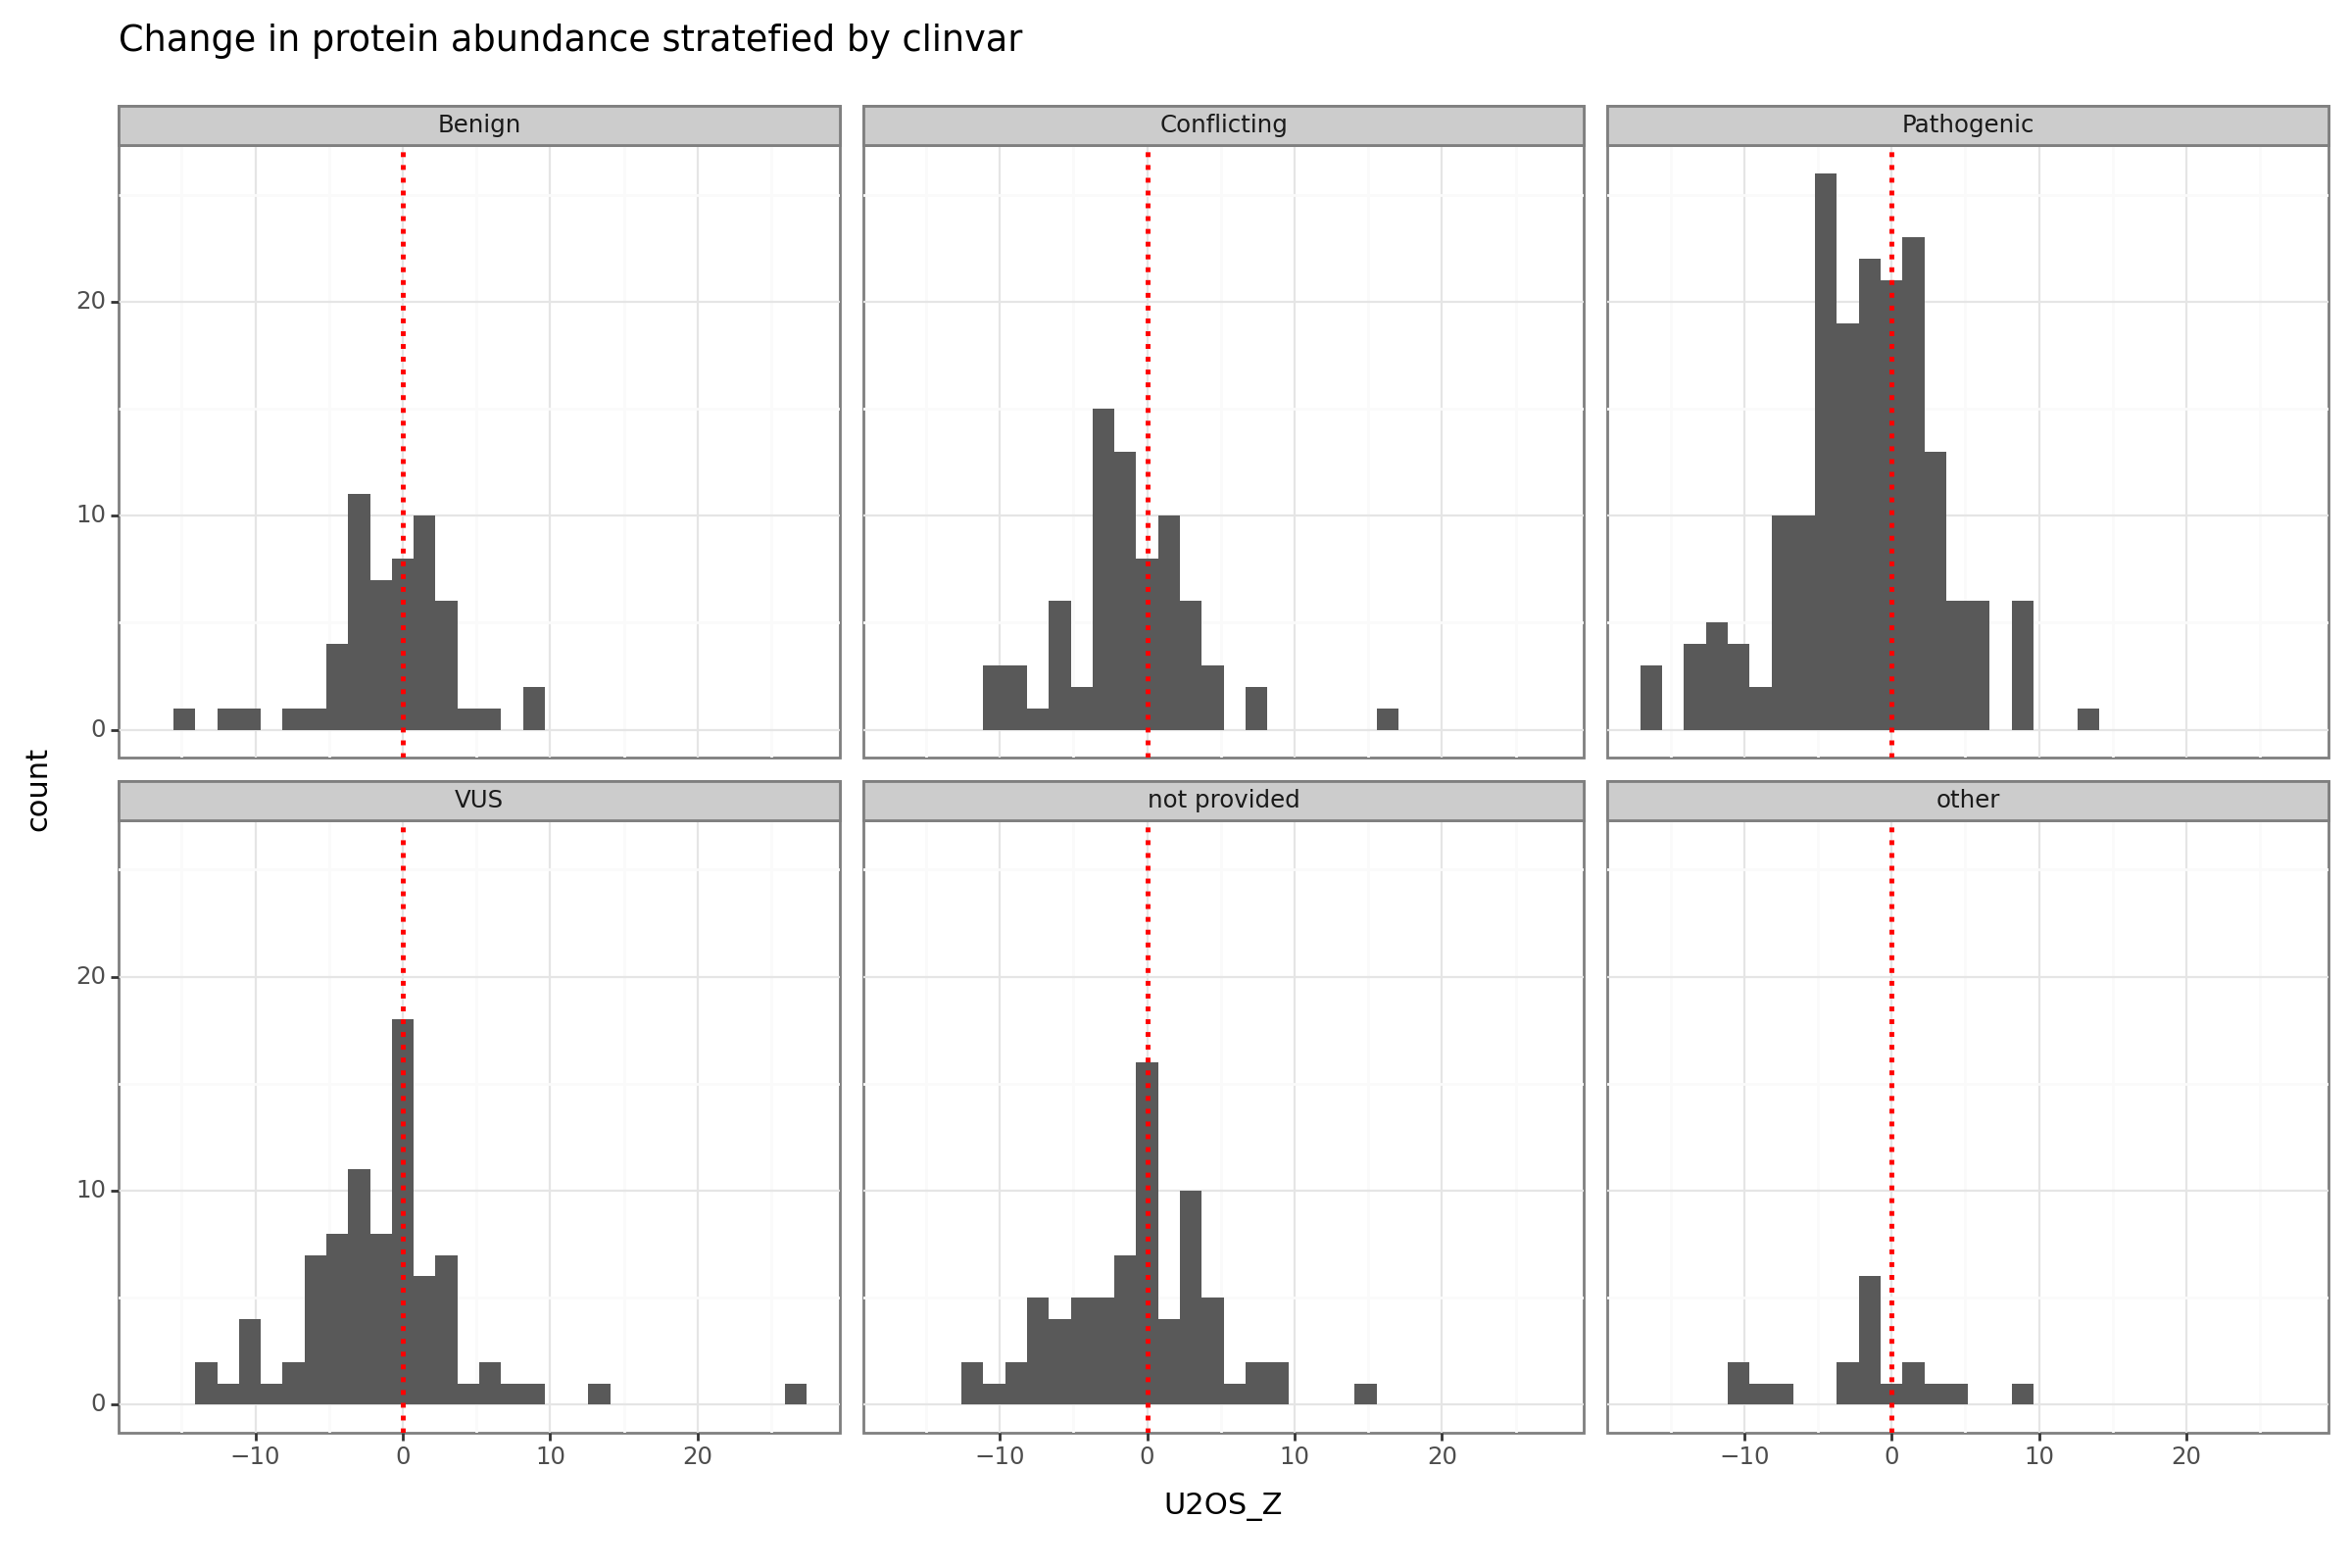

In [11]:
from plotnine import aes, geom_histogram, ggplot, theme_bw, labs, facet_wrap, geom_vline

plotnine.options.figure_size = (12, 8)
plot1 = (
    ggplot(
        well_abun_stats,
        aes(x="U2OS_Z"),
    )
    + geom_histogram()
    + facet_wrap("clinvar_cs")
    + geom_vline(xintercept=0, color="red", linetype="dotted", size=1)
    + theme_bw()
    + labs(title="Change in protein abundance stratefied by clinvar")
)
print(plot1)

## Compare USO2 to DUAL using raw values

Discussion of columns in this dataset:

- avg_gfp: average GFP signal (actual protein abundance level)
- avg_mcherry: average mCherry signal (overexpression level)
- avg_GFP_mCherry_ratio: abundance:expression - this should give a measure of stability
- valid_well: did the well pass various QA/QC thresholds?
    - 800 cells with mCherry > 500 (similar to imaging selection agent + cell count filter)
    - avg reference GFP > 100
- valid_gfp_mcherry_ratio: I don't know how this is different from 'valid_well'

Analysis questions
- what is the correlation between U2OS GFP intensity versus avg_GFP?
    - Do not compare z-stats ... would have to re-compute z-stats using only avg_GFP and not avg_GFP_mCherry_ratio
    - Try for all, valid_well, and valid_gfp_mcherry_ratio
    - Compute median value across all batches (imaging) and mut_id (DUAL)

In [12]:
# Get SC intensity values
b7_alleles = (
    pl.scan_parquet(
        f"{prof_dir}/2024_01_23_Batch_7/profiles_tcdropped_filtered_var_mad_outlier_featselect_filtcells_metacorr.parquet"
    )
    .select([
        "Metadata_CellID",
        "Metadata_gene_allele",
        "Metadata_Well",
        "Metadata_Plate",
    ])
)
b8_alleles = (
    pl.scan_parquet(
        f"{prof_dir}/2024_02_06_Batch_8/profiles_tcdropped_filtered_var_mad_outlier_featselect_filtcells_metacorr.parquet"
    )
    .select([
        "Metadata_CellID",
        "Metadata_gene_allele",
        "Metadata_Well",
        "Metadata_Plate",
    ])
)

cell_alleles = pl.concat([b7_alleles.collect(), b8_alleles.collect()])

b7_prof = pl.scan_parquet(
    f"{prof_dir}/2024_01_23_Batch_7/profiles.parquet"
).with_columns(
    pl.concat_str(
        [
            "Metadata_Plate",
            "Metadata_Well",
            "Metadata_ImageNumber",
            "Metadata_ObjectNumber",
        ],
        separator="_",
    ).alias("Metadata_CellID")
)
b8_prof = pl.scan_parquet(
    f"{prof_dir}/2024_02_06_Batch_8/profiles.parquet"
).with_columns(
    pl.concat_str(
        [
            "Metadata_Plate",
            "Metadata_Well",
            "Metadata_ImageNumber",
            "Metadata_ObjectNumber",
        ],
        separator="_",
    ).alias("Metadata_CellID")
)

In [13]:
# Take median
gfp_int = pl.concat([
    b7_prof.select(["Metadata_CellID", "Cells_Intensity_MedianIntensity_GFP"]).collect(),
    b8_prof.select(["Metadata_CellID", "Cells_Intensity_MedianIntensity_GFP"]).collect(),
])

gfp_int = cell_alleles.join(gfp_int, on="Metadata_CellID", how="left")

gfp_int = gfp_int.group_by("Metadata_gene_allele").agg(
    pl.mean("Cells_Intensity_MedianIntensity_GFP").alias("Mean_GFP_Intensity")
)

In [14]:
# Combine with dual stats
dual_stats = pl.read_csv("../results/pDEST_DUAL_avg.tsv", separator="\t")
dual_stats = dual_stats.with_columns(
    pl.when(pl.col("aa_change") == "WT").then("symbol").otherwise(
        pl.concat_str(["symbol", "aa_change"], separator="_")
    ).alias("Metadata_gene_allele")
)

dual_stats_nofilt = dual_stats.group_by("Metadata_gene_allele").agg(
    pl.mean("avg_gfp").alias("avg_gfp"),
    pl.mean("avg_GFP_mCherry_ratio").alias("avg_GFP_mCherry_ratio")
)

dual_stats_wellfilt = dual_stats.filter(pl.col("valid_well") == True).group_by("Metadata_gene_allele").agg(
    pl.mean("avg_gfp").alias("avg_gfp"),
    pl.mean("avg_GFP_mCherry_ratio").alias("avg_GFP_mCherry_ratio")
)

dual_stats_ratiofilt = dual_stats.filter(pl.col("valid_gfp_mcherry_ratio") == True).group_by("Metadata_gene_allele").agg(
    pl.mean("avg_gfp").alias("avg_gfp"),
    pl.mean("avg_GFP_mCherry_ratio").alias("avg_GFP_mCherry_ratio")
)

In [15]:
gfp_int_nofilt = gfp_int.join(dual_stats_nofilt, on="Metadata_gene_allele")
gfp_int_wellfilt = gfp_int.join(dual_stats_wellfilt, on="Metadata_gene_allele")
gfp_int_ratiofilt = gfp_int.join(dual_stats_ratiofilt, on="Metadata_gene_allele")

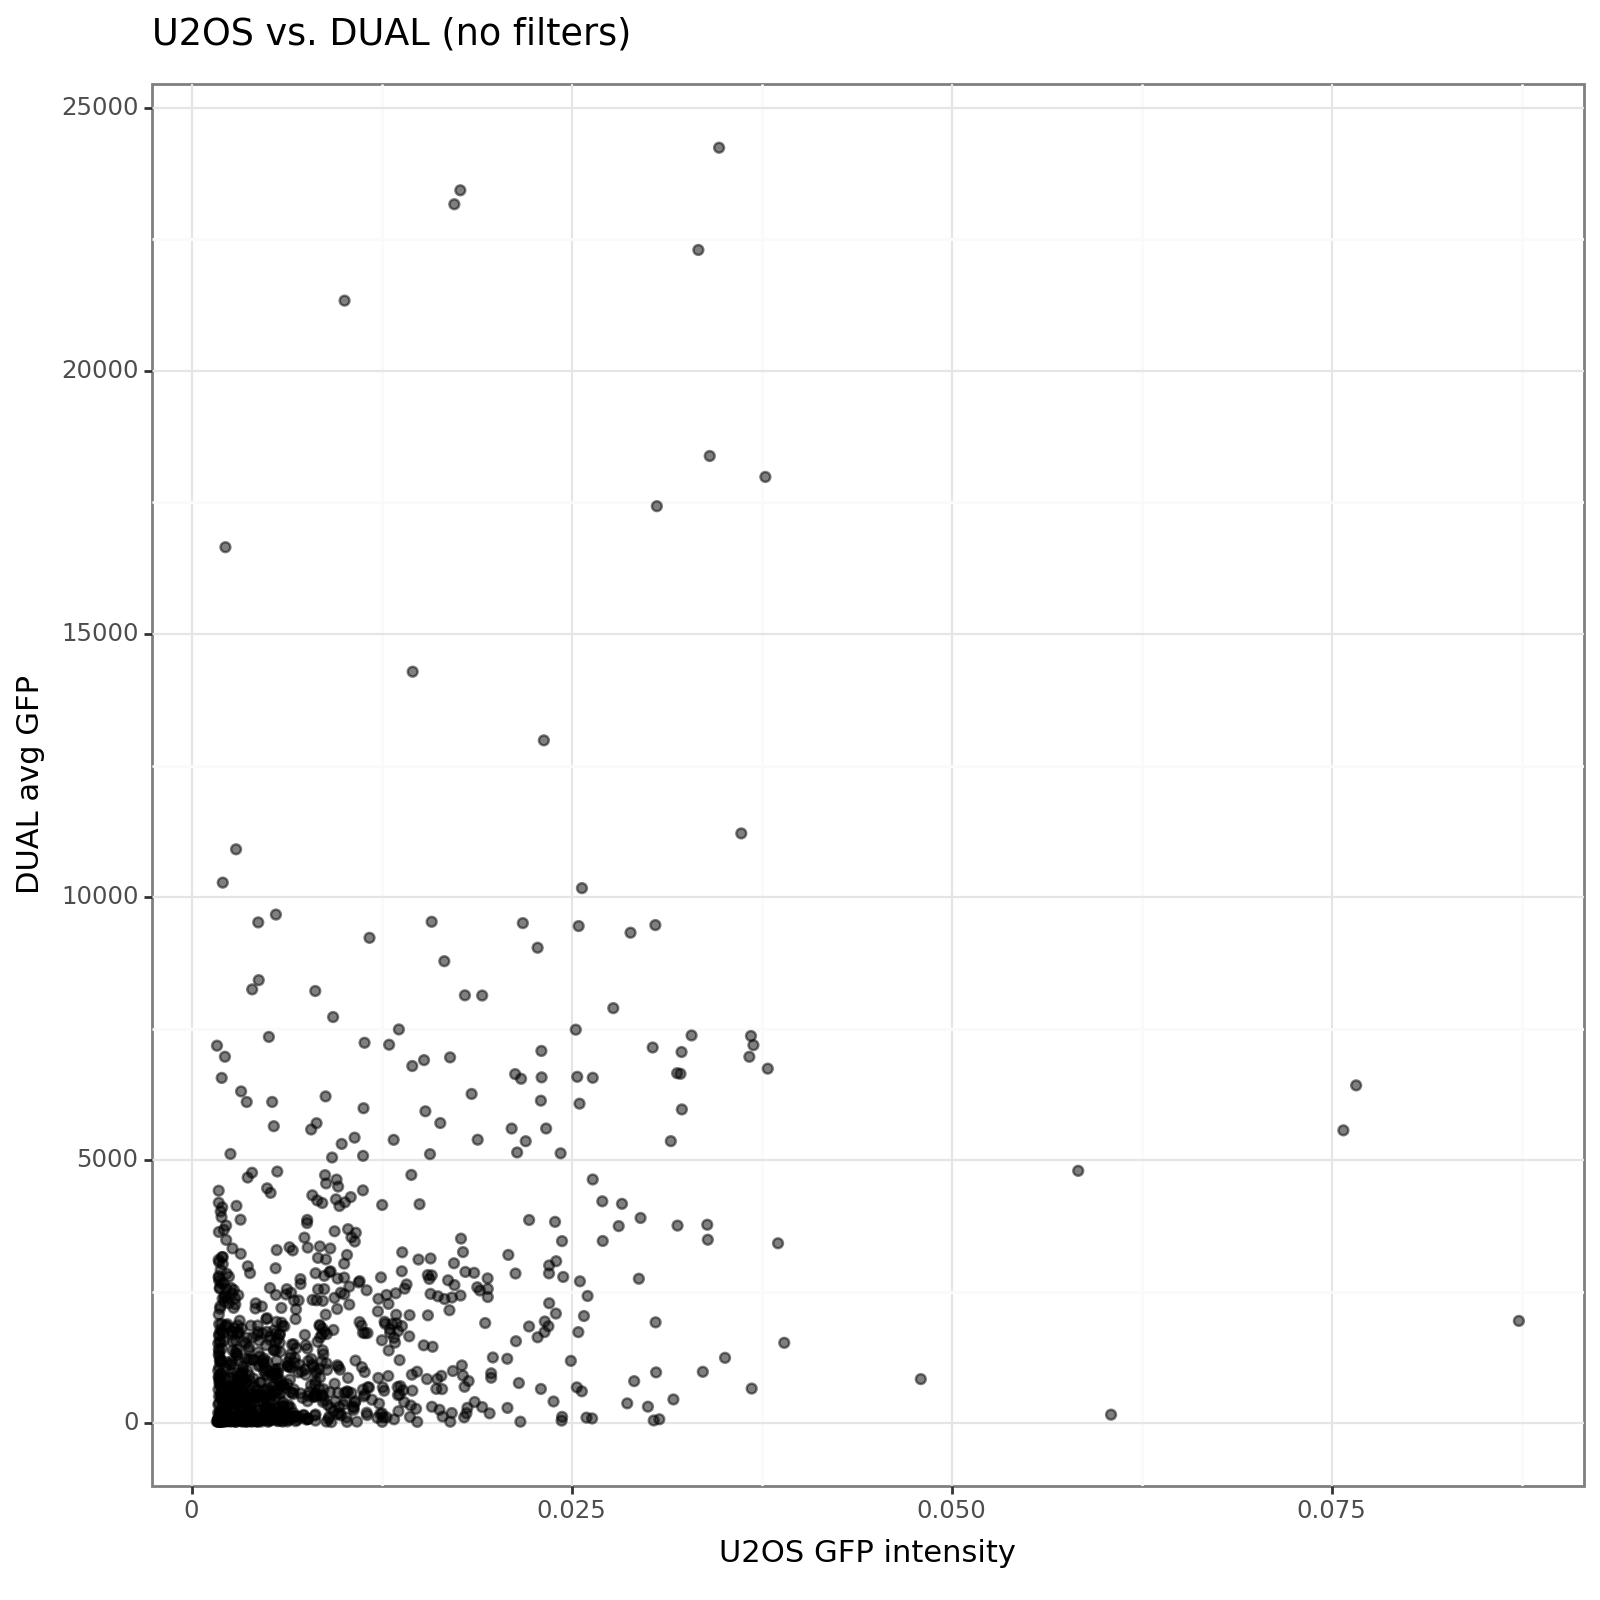

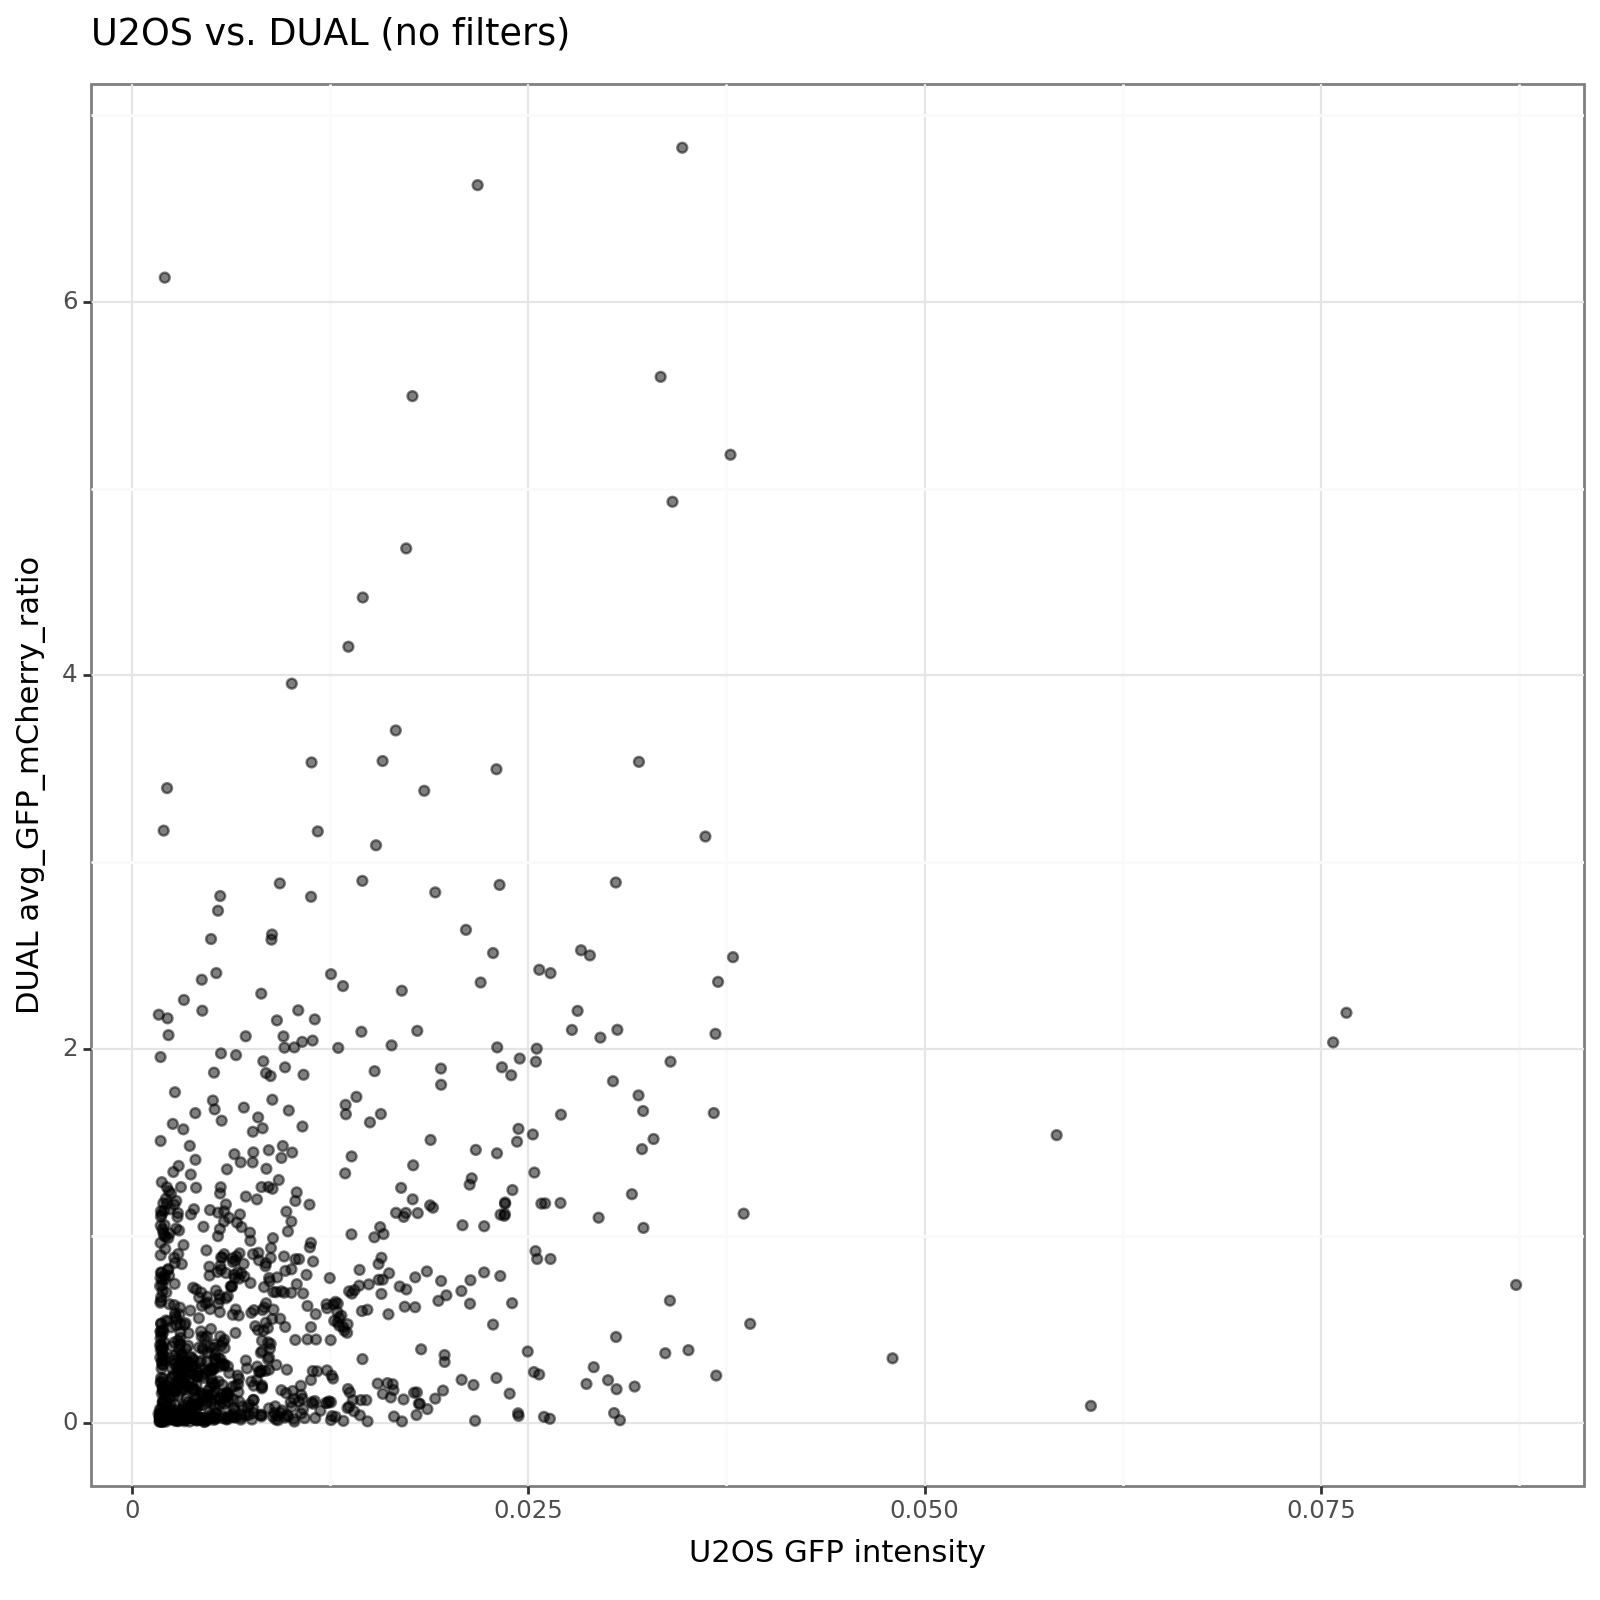

In [16]:
from plotnine import aes, geom_point, ggplot, theme_bw, labs
plotnine.options.figure_size = (8, 8)

plot1 = (
    ggplot(
        gfp_int_nofilt,
        aes(x="Mean_GFP_Intensity", y="avg_gfp"),
    )
    + geom_point(alpha=0.5)
    + theme_bw()
    + labs(title="U2OS vs. DUAL (no filters)", x="U2OS GFP intensity", y="DUAL avg GFP")
)
print(plot1)

plot1 = (
    ggplot(
        gfp_int_nofilt,
        aes(x="Mean_GFP_Intensity", y="avg_GFP_mCherry_ratio"),
    )
    + geom_point(alpha=0.5)
    + theme_bw()
    + labs(title="U2OS vs. DUAL (no filters)", x="U2OS GFP intensity", y="DUAL avg_GFP_mCherry_ratio")
)
print(plot1)

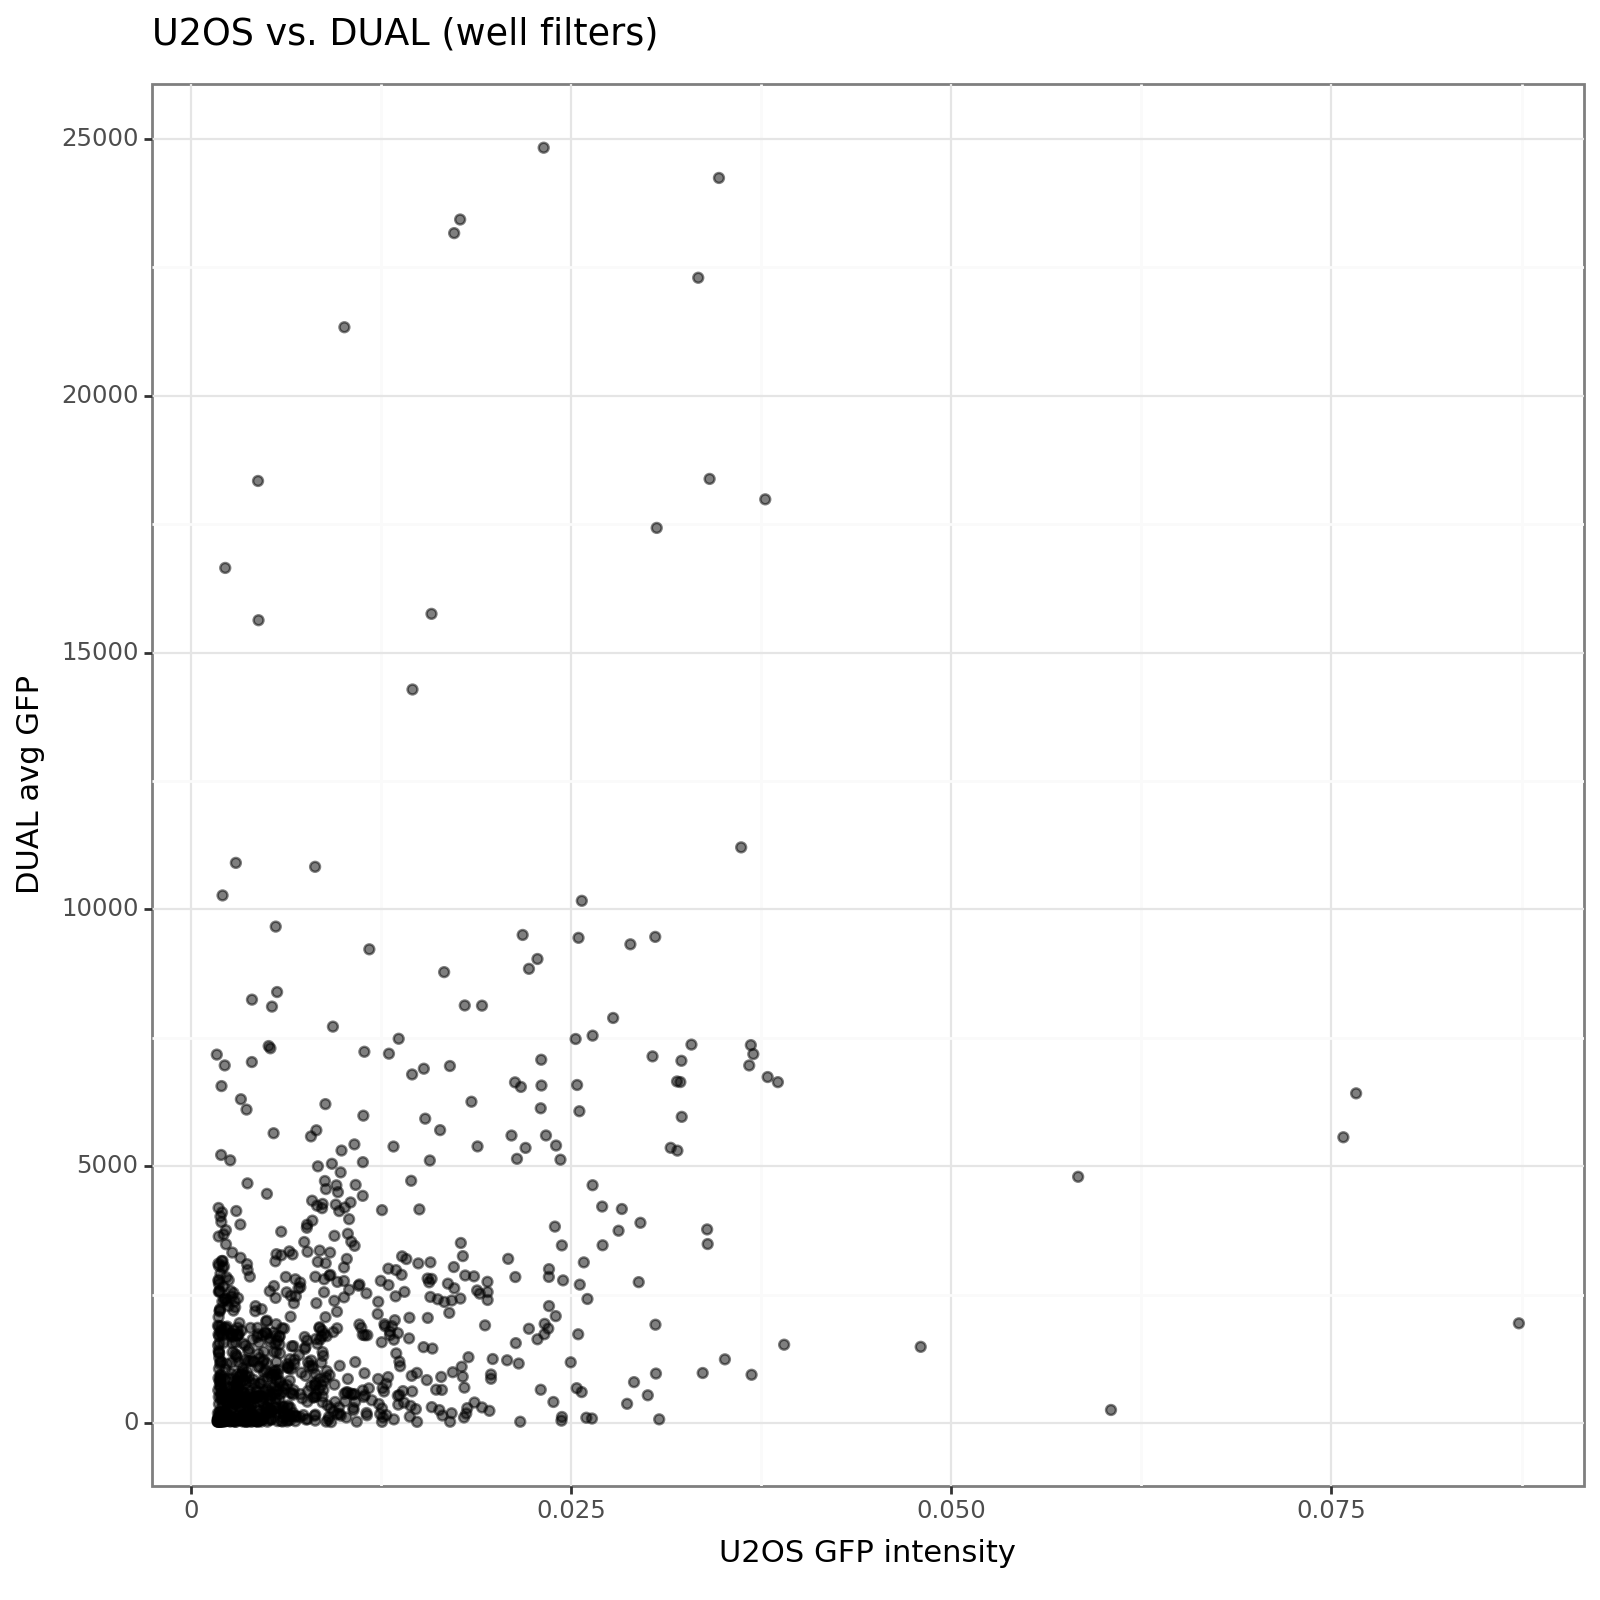

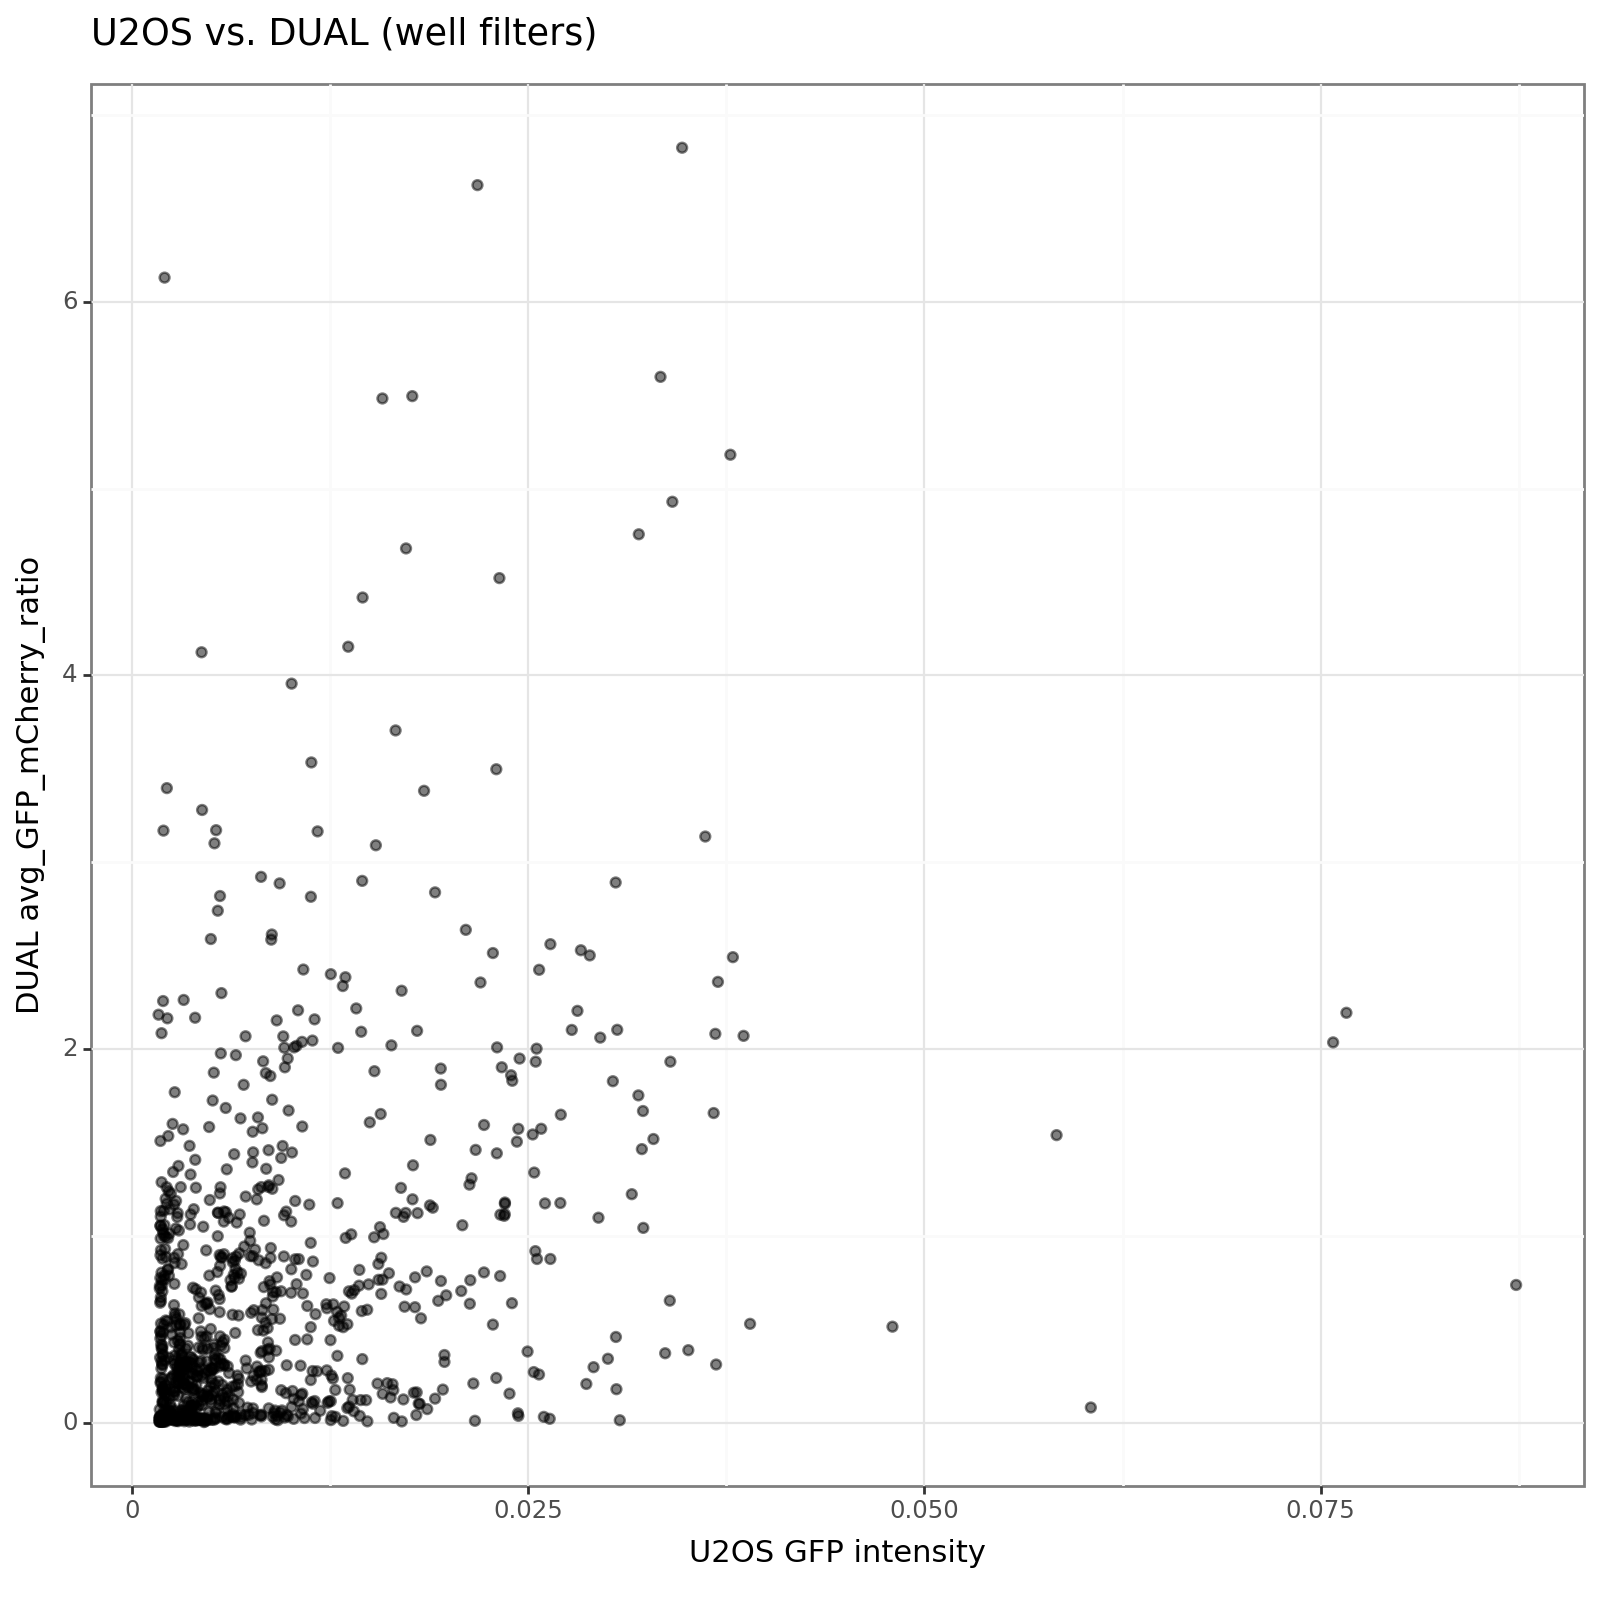

In [17]:
from plotnine import aes, geom_point, ggplot, theme_bw, labs
plotnine.options.figure_size = (8, 8)

plot1 = (
    ggplot(
        gfp_int_wellfilt,
        aes(x="Mean_GFP_Intensity", y="avg_gfp"),
    )
    + geom_point(alpha=0.5)
    + theme_bw()
    + labs(title="U2OS vs. DUAL (well filters)", x="U2OS GFP intensity", y="DUAL avg GFP")
)
print(plot1)

plot1 = (
    ggplot(
        gfp_int_wellfilt,
        aes(x="Mean_GFP_Intensity", y="avg_GFP_mCherry_ratio"),
    )
    + geom_point(alpha=0.5)
    + theme_bw()
    + labs(title="U2OS vs. DUAL (well filters)", x="U2OS GFP intensity", y="DUAL avg_GFP_mCherry_ratio")
)
print(plot1)

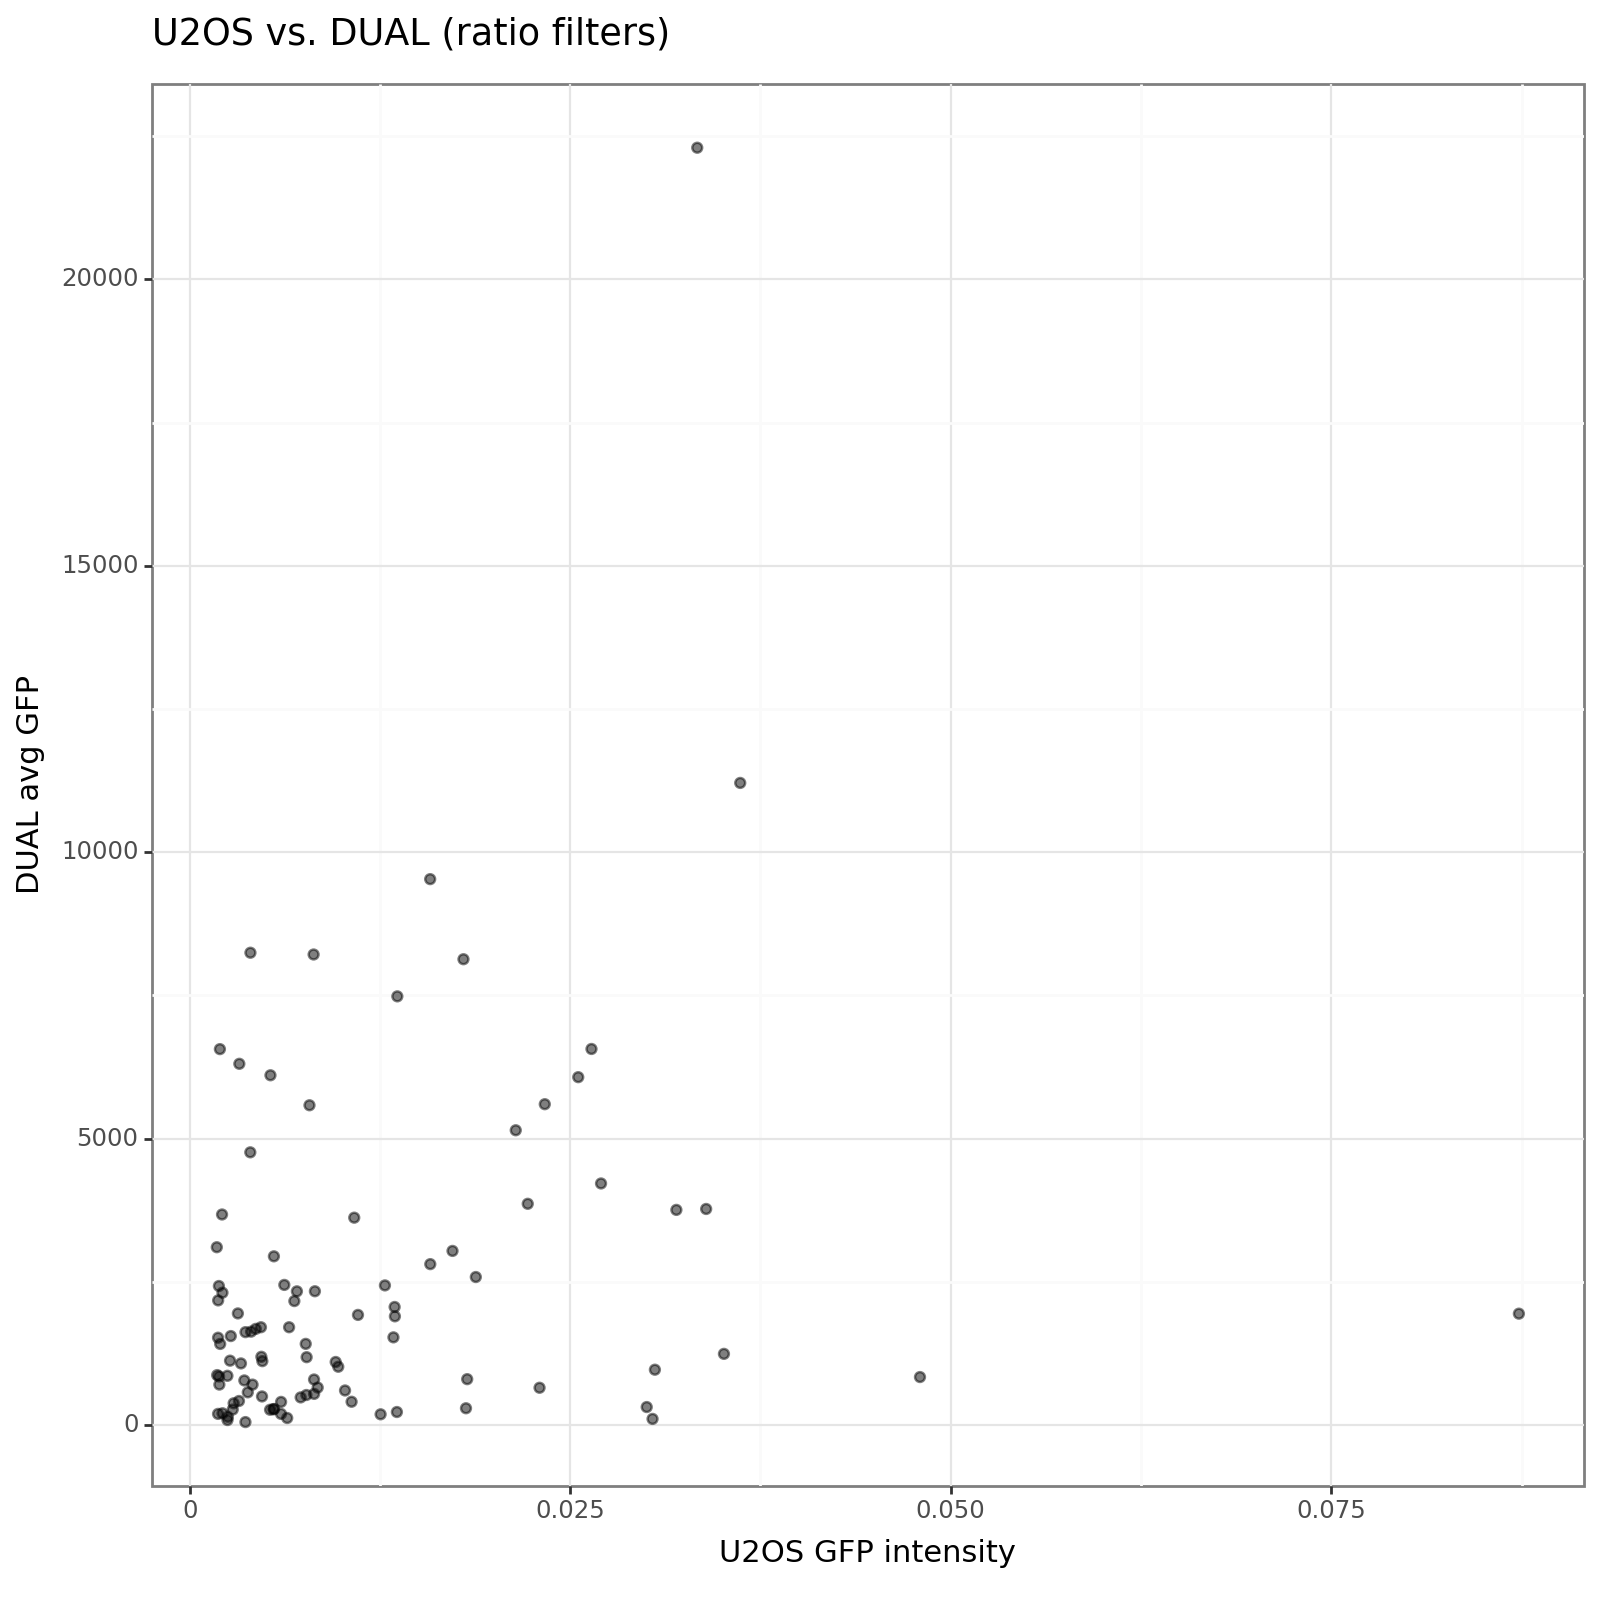

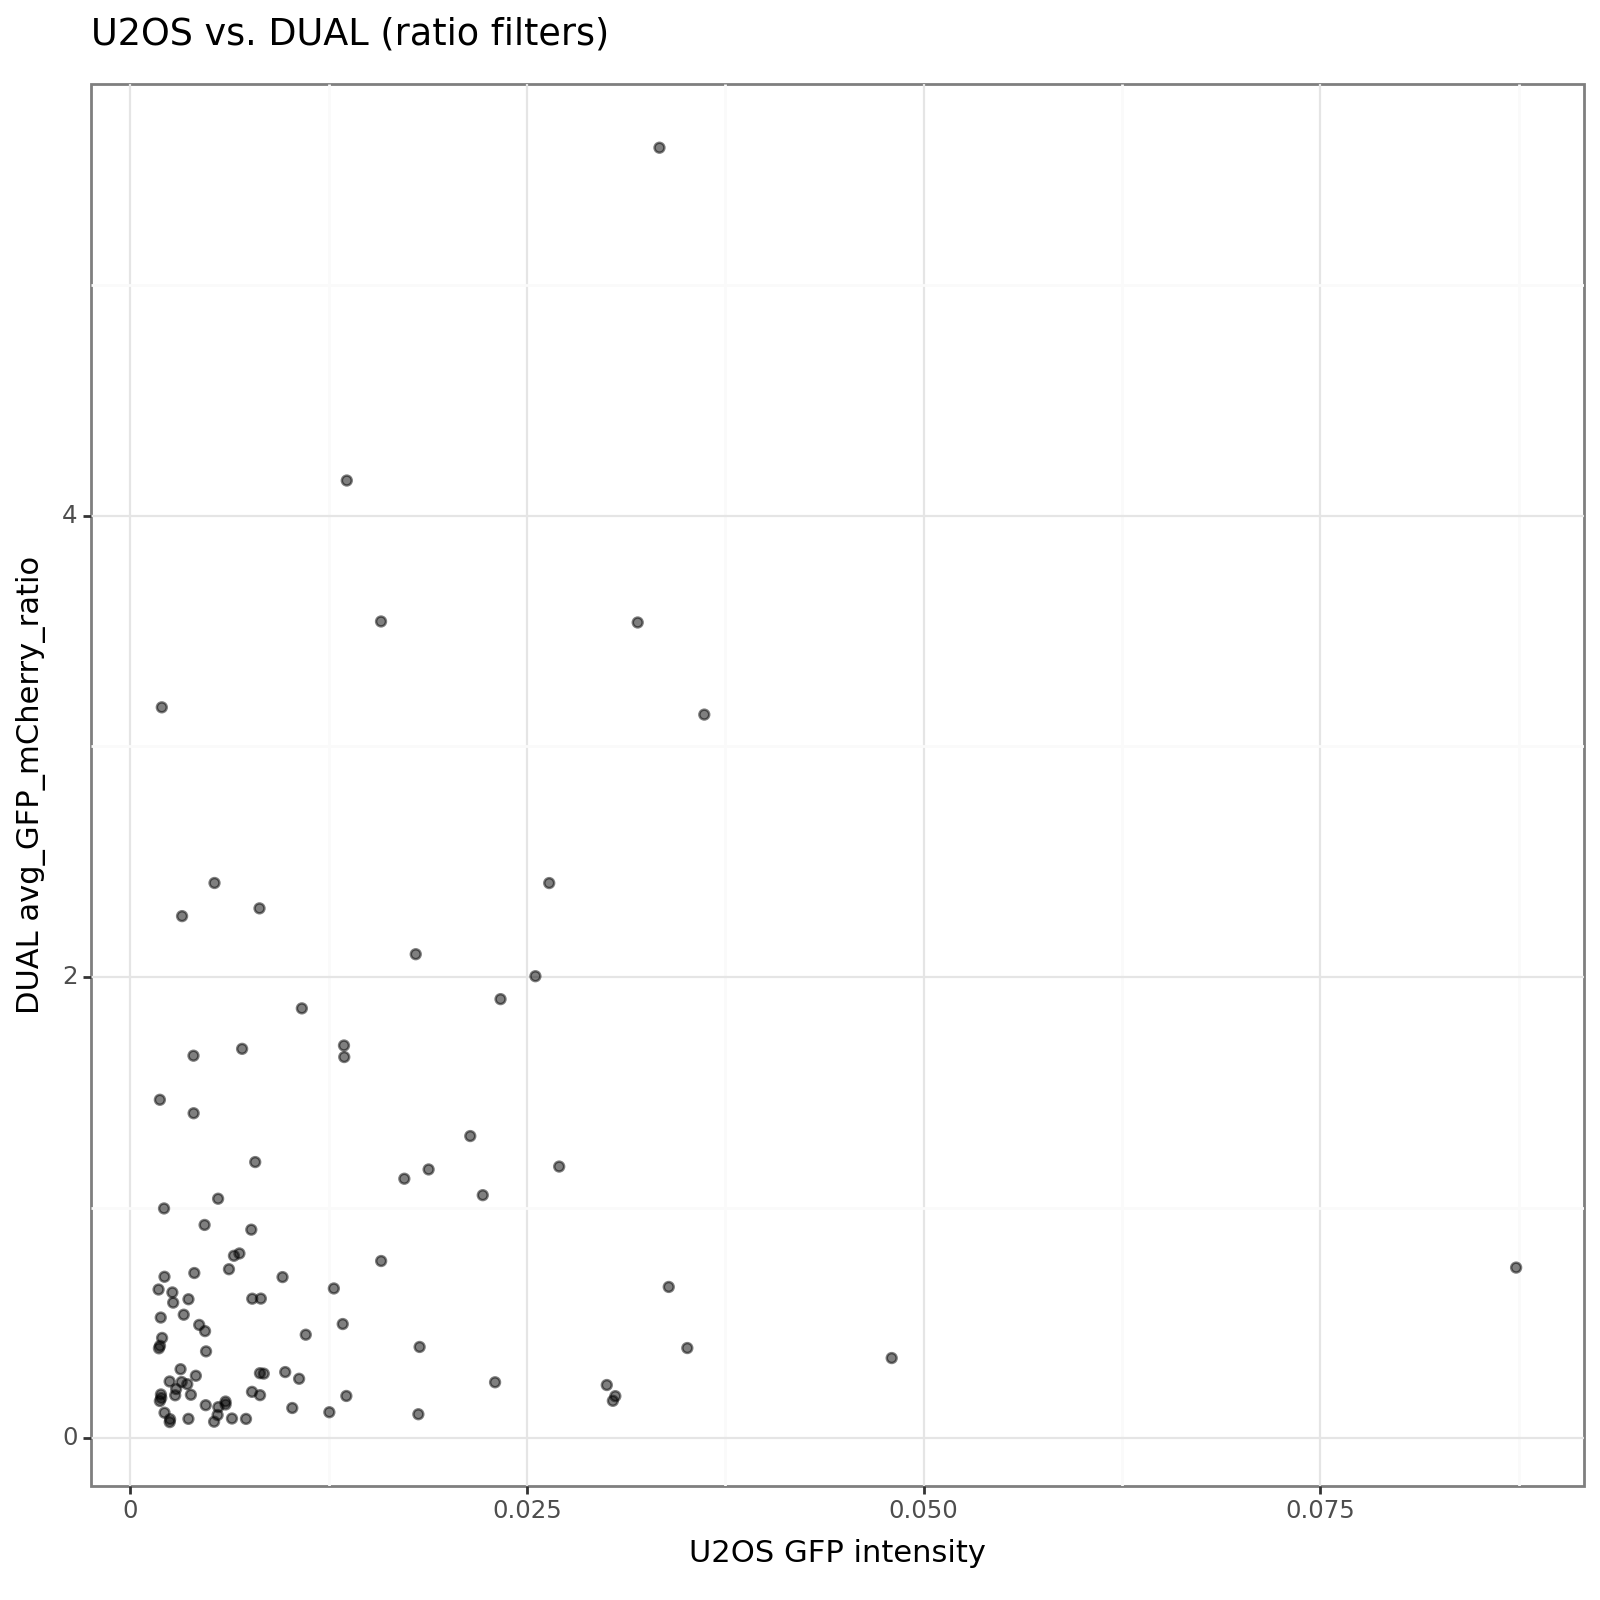

In [18]:
from plotnine import aes, geom_point, ggplot, theme_bw, labs
plotnine.options.figure_size = (8, 8)

plot1 = (
    ggplot(
        gfp_int_ratiofilt,
        aes(x="Mean_GFP_Intensity", y="avg_gfp"),
    )
    + geom_point(alpha=0.5)
    + theme_bw()
    + labs(title="U2OS vs. DUAL (ratio filters)", x="U2OS GFP intensity", y="DUAL avg GFP")
)
print(plot1)

plot1 = (
    ggplot(
        gfp_int_ratiofilt,
        aes(x="Mean_GFP_Intensity", y="avg_GFP_mCherry_ratio"),
    )
    + geom_point(alpha=0.5)
    + theme_bw()
    + labs(title="U2OS vs. DUAL (ratio filters)", x="U2OS GFP intensity", y="DUAL avg_GFP_mCherry_ratio")
)
print(plot1)

Conclusions:
- I see no correlation between raw GFP intensity between assays
- Using GFP:mCherry ratio from DUAL does not help
- Filtering the DUAL data by various criteria does not help

Next steps: get Z-stats computed from just the avg_gfp values, not from the gfp:mCherry ratios.